 JLR Triton/CUDA Demo (Fixed & Complete)
**Complete pipeline**: GPU setup → Kernel verification → EvoNorm → CNN training → Profiling → Reports
 Run cells in order! Each section builds on the previous.

## 0️⃣ GPU Setup & Verification

In [ ]:

import os, torch
print('✅ CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f'🎮 GPU: {device_name}')
    print(f'💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
    os.system('nvidia-smi -L || true')
else:
    print('⚠️ WARNING: No CUDA GPU detected! Using CPU (will be slow)')


✅ CUDA available: True
🎮 GPU: Tesla T4
💾 GPU Memory: 15.83 GB


In [ ]:

# 📦 Install dependencies (uncomment if needed)
# %pip install -q torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121
# %pip install -q triton pandas matplotlib seaborn


## 1️⃣ Imports, Setup, Utilities

In [ ]:
import os, math, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

import triton
import triton.language as tl
import torch
import time

import time
import torch

def profile_time_and_memory(func, *args, repeat: int = 1, **kwargs):
    """
    Run `func` multiple times, measure avg time (ms) and peak GPU memory (MB).
    """
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    result = None
    t0 = time.perf_counter()
    for _ in range(repeat):
        result = func(*args, **kwargs)
    torch.cuda.synchronize()

    elapsed_ms = (time.perf_counter() - t0) * 1e3 / repeat
    peak_mem_mb = torch.cuda.max_memory_allocated() / 1024**2
    return result, elapsed_ms, peak_mem_mb



# Seeds & device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🔧 Device: {device}')

# Create directories
os.makedirs('reports/demo_pack', exist_ok=True)
os.makedirs('profiling/benchmark_results', exist_ok=True)
os.makedirs('profiling/nsight_scripts', exist_ok=True)
print('✅ Directories created')

# Safe display
try:
    from IPython.display import display
except:
    def display(x): print(x)

def time_ms(fn, iters=60, warmup=10):
    """Measure average execution time in milliseconds"""
    with torch.no_grad():
        for _ in range(warmup):
            fn()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        s = torch.cuda.Event(True)
        e = torch.cuda.Event(True)
        s.record()
        for _ in range(iters):
            fn()
        e.record()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        return s.elapsed_time(e) / iters

print('✅ Utilities loaded')

def analyze_performance_summary(bench_df):
    """Generate a comprehensive performance analysis summary"""
    if 'speedup' not in bench_df.columns:
        bench_df['speedup'] = bench_df['torch_ms'] / bench_df['triton_ms']

    summary = {
        'total_operations': len(bench_df),
        'average_speedup': bench_df['speedup'].mean(),
        'median_speedup': bench_df['speedup'].median(),
        'max_speedup': bench_df['speedup'].max(),
        'min_speedup': bench_df['speedup'].min(),
        'triton_faster_count': (bench_df['speedup'] > 1).sum(),
        'pytorch_faster_count': (bench_df['speedup'] < 1).sum(),
        'break_even_count': (bench_df['speedup'] == 1).sum(),
        'best_operation': bench_df.loc[bench_df['speedup'].idxmax(), 'op'],
        'worst_operation': bench_df.loc[bench_df['speedup'].idxmin(), 'op']
    }

    return summary


🔧 Device: cuda
✅ Directories created
✅ Utilities loaded


In [ ]:
# The profile_time_and_memory function in cell dbffa9e5 is the intended one for this notebook.
# This redefinition is causing a TypeError in later cells due to the missing 'repeat' argument.
# Removing this redefinition to ensure the correct function from dbffa9e5 is used.


## 2️⃣ Triton Kernels: ReLU, Sigmoid, Softmax

In [ ]:

@triton.jit
def relu_kernel(x_ptr, y_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements
    x = tl.load(x_ptr + offs, mask=mask, other=0.0)
    y = tl.maximum(x, 0.0)
    tl.store(y_ptr + offs, y, mask=mask)

def relu_triton(x):
    assert x.is_cuda and x.is_contiguous()
    y = torch.empty_like(x)
    n = x.numel()
    BLOCK = 1024
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)
    relu_kernel[grid](x, y, n, BLOCK_SIZE=BLOCK)
    return y

@triton.jit
def sigmoid_kernel(x_ptr, y_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements
    x = tl.load(x_ptr + offs, mask=mask, other=0.0)
    y = 1.0 / (1.0 + tl.exp(-x))
    tl.store(y_ptr + offs, y, mask=mask)

def sigmoid_triton(x):
    assert x.is_cuda and x.is_contiguous()
    y = torch.empty_like(x)
    n = x.numel()
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)
    sigmoid_kernel[grid](x, y, n, BLOCK_SIZE=1024)
    return y

@triton.jit
def softmax_rowwise_kernel(x_ptr, y_ptr, n_rows, n_cols,
                           stride_xr, stride_xc, stride_yr, stride_yc,
                           BLOCK_SIZE: tl.constexpr):
    row_id = tl.program_id(axis=0)
    cols = tl.arange(0, BLOCK_SIZE)
    row_ptr_x = x_ptr + row_id * stride_xr
    row_ptr_y = y_ptr + row_id * stride_yr
    mask = cols < n_cols
    x = tl.load(row_ptr_x + cols * stride_xc, mask=mask, other=-float('inf'))
    x_max = tl.max(x, axis=0)
    x = x - x_max
    expx = tl.exp(x)
    denom = tl.sum(expx, axis=0)
    out = expx / denom
    tl.store(row_ptr_y + cols * stride_yc, out, mask=mask)

def softmax_triton_lastdim(x):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols)
    y2 = torch.empty_like(x2)
    BLOCK = 1024
    assert cols <= BLOCK, f'Dims must be <= {BLOCK}'
    grid = (rows,)
    softmax_rowwise_kernel[grid](
        x2, y2, rows, cols,
        x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1),
        BLOCK_SIZE=BLOCK
    )
    return y2.view_as(x)

print('✅ Basic kernels defined')


✅ Basic kernels defined


## 3️⃣ Triton LayerNorm

In [ ]:

@triton.jit
def layernorm_fwd_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr,
                         n_rows, n_cols,
                         stride_xr, stride_xc, stride_yr, stride_yc,
                         eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    x_row = x_ptr + row * stride_xr + cols * stride_xc
    y_row = y_ptr + row * stride_yr + cols * stride_yc
    x = tl.load(x_row, mask=mask, other=0.0).to(tl.float32)
    m = tl.sum(x, axis=0) / n_cols
    xc = x - m
    v = tl.sum(xc * xc, axis=0) / n_cols
    inv = tl.rsqrt(v + eps)
    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0).to(tl.float32)
    beta = tl.load(beta_ptr + cols, mask=mask, other=0.0).to(tl.float32)
    y = (xc * inv) * gamma + beta
    tl.store(y_row, y, mask=mask)

def layernorm_triton(x, gamma, beta, eps=1e-5):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous()
    y2 = torch.empty_like(x2)
    BLOCK = 1 << (cols - 1).bit_length()
    BLOCK = min(BLOCK, 4096)
    grid = (rows,)
    layernorm_fwd_kernel[grid](
        x2, y2, gamma, beta, rows, cols,
        x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1),
        eps=eps, BLOCK_SIZE=BLOCK
    )
    return y2.view_as(x)

print('✅ LayerNorm kernel defined')


✅ LayerNorm kernel defined


## 🧪 VERIFICATION: Test Kernel Correctness

In [ ]:

print('\n🧪 Testing Kernel Correctness...\n')

def test_kernel(name, triton_fn, torch_fn, x, *args, rtol=1e-4, atol=1e-5):
    """Test if triton kernel matches PyTorch"""
    try:
        y_triton = triton_fn(x, *args)
        y_torch = torch_fn(x, *args)
        match = torch.allclose(y_triton, y_torch, rtol=rtol, atol=atol)
        max_diff = (y_triton - y_torch).abs().max().item()
        status = '✅' if match else '❌'
        print(f'{status} {name:15s} | Max diff: {max_diff:.2e} | Match: {match}')
        return match
    except Exception as e:
        print(f'❌ {name:15s} | ERROR: {e}')
        return False

x_test = torch.randn(128, 256, device=device, dtype=torch.float32)

test_kernel('ReLU', relu_triton, lambda x: F.relu(x), x_test)
test_kernel('Sigmoid', sigmoid_triton, lambda x: torch.sigmoid(x), x_test)
test_kernel('Softmax', softmax_triton_lastdim, lambda x: F.softmax(x, dim=-1), x_test)

gamma = torch.ones(256, device=device, dtype=torch.float32)
beta = torch.zeros(256, device=device, dtype=torch.float32)
test_kernel('LayerNorm',
            lambda x, g, b: layernorm_triton(x, g, b),
            lambda x, g, b: F.layer_norm(x, (256,), g, b),
            x_test, gamma, beta)

print('\n✅ Verification complete!\n')



🧪 Testing Kernel Correctness...

✅ ReLU            | Max diff: 0.00e+00 | Match: True
✅ Sigmoid         | Max diff: 1.79e-07 | Match: True
✅ Softmax         | Max diff: 1.49e-08 | Match: True
✅ LayerNorm       | Max diff: 7.15e-07 | Match: True

✅ Verification complete!



## 4️⃣ EvoNorm-B0 (Reference, Apply, Fused)

In [ ]:
def evonorm_b0_reference(x, v, groups=32, eps=1e-5):
    """PyTorch reference implementation (NCHW)"""
    assert x.dim() == 4, "Expected NCHW"
    N, C, H, W = x.shape
    assert C % groups == 0
    v = v.view(1, C, 1, 1)
    Cg = C // groups
    xg = x.view(N, groups, Cg, H, W)
    var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
    inv_std = torch.rsqrt(var + eps).expand(N, groups, Cg, H, W).reshape(N, C, H, W)
    return x * torch.sigmoid(v * x) * inv_std

@triton.jit
def evonorm_b0_fused_kernel(
    x_ptr, v_ptr, y_ptr, N, C, H, W, groups,
    eps: tl.constexpr, BLOCK: tl.constexpr,
):
    pid = tl.program_id(0)
    g = pid % groups
    n = pid // groups
    Cg = C // groups
    HW = H * W
    group_elems = Cg * HW
    base = n * (C * HW) + g * (Cg * HW)

    # Pass 1: Compute variance
    acc1 = tl.zeros([1], dtype=tl.float32)
    acc2 = tl.zeros([1], dtype=tl.float32)
    offs = tl.arange(0, BLOCK)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs
        mask = (start + offs) < group_elems
        x = tl.load(x_ptr + idx, mask=mask, other=0.0).to(tl.float32)
        acc1 += tl.sum(x, axis=0)
        acc2 += tl.sum(x * x, axis=0)

    ge = tl.full([1], group_elems, dtype=tl.float32)
    mean = acc1 / ge
    var = acc2 / ge - mean * mean
    inv = 1.0 / tl.sqrt(var + eps)

    # Pass 2: Apply normalization
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs
        mask = (start + offs) < group_elems
        x = tl.load(x_ptr + idx, mask=mask, other=0.0).to(tl.float32)
        rel = start + offs
        c_in_group = rel // HW
        c_global = g * Cg + c_in_group
        v = tl.load(v_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
        sig = 1.0 / (1.0 + tl.exp(-(v * x)))
        y = x * sig * inv
        tl.store(y_ptr + idx, y, mask=mask)

def evonorm_b0_triton_fused(x, v, groups=32, eps=1e-5):
    assert x.is_cuda and v.is_cuda
    N, C, H, W = x.shape
    assert C % groups == 0
    x = x.contiguous()
    y = torch.empty_like(x)
    Cg = C // groups
    # Calculate group elements and find the next power of 2 for the block size
    group_elems = Cg * H * W
    BLOCK = int(2**math.ceil(math.log2(group_elems)))
    # Limit the BLOCK size to 1024 as a reasonable maximum
    BLOCK = min(BLOCK, 1024)
    grid = (N * groups,)
    evonorm_b0_fused_kernel[grid](
        x.view(-1), v, y.view(-1), N, C, H, W, groups,
        eps=eps, BLOCK=BLOCK
    )
    return y

print('✅ EvoNorm-B0 kernels defined')

✅ EvoNorm-B0 kernels defined


## 🧪 VERIFICATION: Test EvoNorm Correctness

In [ ]:
print('\n🧪 Testing EvoNorm-B0...\n')
x_ev = torch.randn(2, 32, 28, 28, device=device, dtype=torch.float32)
v_ev = torch.randn(32, device=device, dtype=torch.float32)

y_ref = evonorm_b0_reference(x_ev, v_ev, groups=32)
y_fused = evonorm_b0_triton_fused(x_ev, v_ev, groups=32)

match = torch.allclose(y_ref, y_fused, rtol=1e-3, atol=1e-4)
max_diff = (y_ref - y_fused).abs().max().item()

status = '✅' if match else '❌'
print(f'{status} EvoNorm-B0 Fused | Max diff: {max_diff:.2e} | Match: {match}')
print('✅ EvoNorm verification complete!\n')


🧪 Testing EvoNorm-B0...

✅ EvoNorm-B0 Fused | Max diff: 9.54e-07 | Match: True
✅ EvoNorm verification complete!



## 5️⃣ Conv + EvoNorm Fused Epilogue

In [ ]:
@triton.jit
def conv_evonorm_epilogue_kernel(
    y_in_ptr, bias_ptr, v_ptr, y_out_ptr,
    N, C, H, W, groups,
    use_bias: tl.constexpr, eps: tl.constexpr, BLOCK: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    g = pid % groups
    n = pid // groups
    Cg = C // groups
    HW = H * W
    group_elems = Cg * HW
    base = n * (C * HW) + g * (Cg * HW)

    # Pass 1: Compute variance (on bias-corrected values if bias exists)
    s1 = tl.zeros([1], dtype=tl.float32)
    s2 = tl.zeros([1], dtype=tl.float32)
    offs = tl.arange(0, BLOCK)

    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs
        mask = (start + offs) < group_elems
        x = tl.load(y_in_ptr + idx, mask=mask, other=0.0).to(tl.float32)

        # Add bias for statistics computation
        if use_bias:
            rel = start + offs
            c_in_group = rel // HW
            c_global = g * Cg + c_in_group
            b = tl.load(bias_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
            x = x + b

        s1 += tl.sum(x, axis=0)
        s2 += tl.sum(x * x, axis=0)

    ge = tl.full([1], group_elems, dtype=tl.float32)
    mean = s1 / ge
    var = s2 / ge - mean * mean
    inv = 1.0 / tl.sqrt(var + eps)

    # Pass 2: Apply EvoNorm (using same bias-corrected x)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs
        mask = (start + offs) < group_elems

        # Load conv output
        x = tl.load(y_in_ptr + idx, mask=mask, other=0.0).to(tl.float32)

        rel = start + offs
        c_in_group = rel // HW
        c_global = g * Cg + c_in_group

        # Add bias (same as pass 1)
        if use_bias:
            b = tl.load(bias_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
            x = x + b

        # EvoNorm: x * sigmoid(v * x) * inv_std
        v_val = tl.load(v_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
        sig = 1.0 / (1.0 + tl.exp(-v_val * x))
        y = x * sig * inv

        tl.store(y_out_ptr + idx, y, mask=mask)

def triton_conv_evonorm_epilogue(y_conv, v, bias=None, groups=32, eps=1e-5):
    assert y_conv.is_cuda
    N, C, H, W = y_conv.shape
    assert C % groups == 0
    y_conv = y_conv.contiguous()
    y_out = torch.empty_like(y_conv)
    Cg = C // groups
    group_elems = Cg * H * W
    assert group_elems > 0, "group_elems must be > 0, check H/W and groups"

    BLOCK = 1
    while BLOCK < group_elems:
        BLOCK <<= 1
    BLOCK = max(32, min(BLOCK, 1024))


    grid = (N * groups,)
    use_bias = 1 if (bias is not None) else 0
    bias_ptr = bias if bias is not None else y_conv.new_empty(1)
    conv_evonorm_epilogue_kernel[grid](
        y_conv.view(-1), bias_ptr, v, y_out.view(-1),
        N, C, H, W, groups,
        use_bias=use_bias, eps=eps, BLOCK=BLOCK
    )
    return y_out

print('✅ Conv+EvoNorm fused epilogue defined')


✅ Conv+EvoNorm fused epilogue defined


In [ ]:
import torch
from torch.autograd import Function

class _EvoNormB0EpilogueFn(Function):
    @staticmethod
    def forward(ctx, x, v, bias=None, groups: int = 32, eps: float = 1e-5):
        # Use existing fast Triton forward
        y = triton_conv_evonorm_epilogue(x, v, bias=bias, groups=groups, eps=eps)
        # Save for backward
        ctx.groups = groups
        ctx.eps = eps
        ctx.have_bias = bias is not None
        if bias is None:
            bias = torch.zeros(x.shape[1], device=x.device, dtype=x.dtype)
        ctx.save_for_backward(x, v, bias)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        groups = ctx.groups
        eps = ctx.eps
        have_bias = ctx.have_bias
        x, v, bias = ctx.saved_tensors

        # Recompute y with PyTorch ops and get dL/dx, dL/dv, dL/db via autograd
        with torch.enable_grad():
            x_ = x.detach().requires_grad_(True)
            v_ = v.detach().requires_grad_(True)
            b_ = bias.detach().requires_grad_(True)

            z = x_ + b_.view(1, -1, 1, 1)
            # Reference EvoNorm-B0 (same as your cell #13)
            N, C, H, W = z.shape
            Cg = C // groups
            xg = z.view(N, groups, Cg, H, W)
            var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
            inv_std = torch.rsqrt(var + eps).expand(N, groups, Cg, H, W).reshape(N, C, H, W)
            y_ref = z * torch.sigmoid(v_.view(1, C, 1, 1) * z) * inv_std

            grads = torch.autograd.grad(y_ref, (x_, v_, b_), grad_y, allow_unused=True)
            grad_x = grads[0]
            grad_v = grads[1]
            grad_b = grads[2] if have_bias else None

        # Return grads aligned to inputs of apply: (x, v, bias, groups, eps)
        return grad_x, grad_v, grad_b, None, None

def evonorm_b0_triton_autograd(x, v, bias=None, groups=32, eps=1e-5):
    return _EvoNormB0EpilogueFn.apply(x, v, bias, groups, eps)

print("✅ Autograd wrapper: evonorm_b0_triton_autograd")

✅ Autograd wrapper: evonorm_b0_triton_autograd


In [ ]:
# Numerical test
torch.manual_seed(42)
x = torch.randn(2, 32, 28, 28, device='cuda')
v = torch.randn(32, device='cuda')

# Reference
ref = evonorm_b0_reference(x, v, groups=32)

# Your fused version (after replacing the kernel)
fused = triton_conv_evonorm_epilogue(x, v, bias=None, groups=32)

print(f"Max diff: {(ref - fused).abs().max().item():.2e}")
print(f"Mean diff: {(ref - fused).abs().mean().item():.2e}")

# Should be < 1e-5

Max diff: 9.54e-07
Mean diff: 2.70e-08


## 6️⃣ Minimal CNN (MNIST) + EvoNorm epilogue & Benchmark

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.95MB/s]


⏱ Training Reference for 10 epochs...


[Reference] Epoch 01/10  train_loss=0.1105  train_acc=0.9655  test_loss=0.0495  test_acc=0.9835  (16.89s)
[Reference] Epoch 02/10  train_loss=0.0352  train_acc=0.9891  test_loss=0.0503  test_acc=0.9844  (16.85s)
[Reference] Epoch 03/10  train_loss=0.0228  train_acc=0.9928  test_loss=0.0287  test_acc=0.9911  (15.66s)
[Reference] Epoch 04/10  train_loss=0.0157  train_acc=0.9950  test_loss=0.0341  test_acc=0.9898  (15.72s)
[Reference] Epoch 05/10  train_loss=0.0124  train_acc=0.9958  test_loss=0.0317  test_acc=0.9911  (16.10s)
[Reference] Epoch 06/10  train_loss=0.0107  train_acc=0.9967  test_loss=0.0362  test_acc=0.9911  (15.59s)
[Reference] Epoch 07/10  train_loss=0.0079  train_acc=0.9973  test_loss=0.0392  test_acc=0.9907  (16.54s)
[Reference] Epoch 08/10  train_loss=0.0072  train_acc=0.9978  test_loss=0.0319  test_acc=0.9909  (15.49s)
[Reference] Epoch 09/10  train_loss=0.0083  train_acc=0.9973  test_loss=0.0335  test_acc=0.9923  (15.35s)
[Reference] Epoch 10/10  train_loss=0.0059  tr

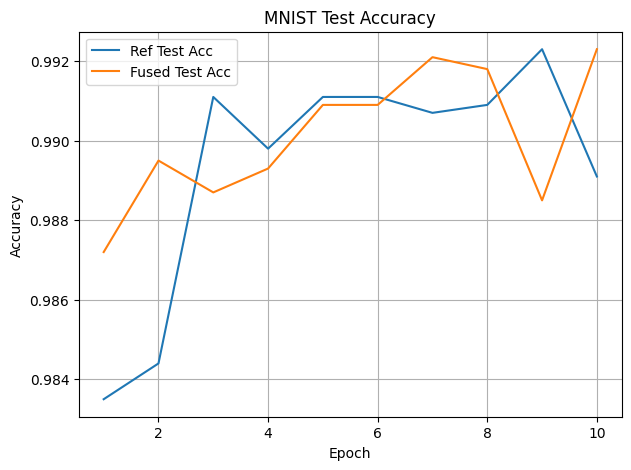

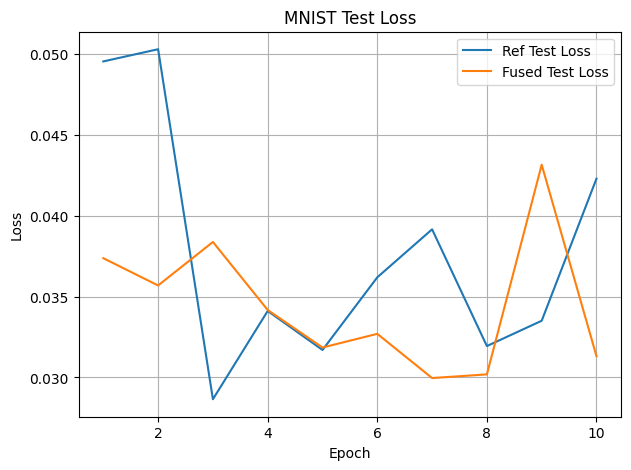


🔥 Training Reference with Focal Loss for 10 epochs...
[Reference_Focal] Epoch 01/10  train_loss=0.0673  train_acc=0.9607  test_loss=0.0727  test_acc=0.9852  (16.53s)
[Reference_Focal] Epoch 02/10  train_loss=0.0155  train_acc=0.9884  test_loss=0.0666  test_acc=0.9884  (17.10s)
[Reference_Focal] Epoch 03/10  train_loss=0.0092  train_acc=0.9921  test_loss=0.0509  test_acc=0.9863  (16.09s)
[Reference_Focal] Epoch 04/10  train_loss=0.0076  train_acc=0.9933  test_loss=0.0468  test_acc=0.9892  (17.46s)
[Reference_Focal] Epoch 05/10  train_loss=0.0065  train_acc=0.9943  test_loss=0.0385  test_acc=0.9902  (16.39s)
[Reference_Focal] Epoch 06/10  train_loss=0.0046  train_acc=0.9955  test_loss=0.0351  test_acc=0.9912  (18.22s)
[Reference_Focal] Epoch 07/10  train_loss=0.0040  train_acc=0.9963  test_loss=0.0397  test_acc=0.9896  (16.84s)
[Reference_Focal] Epoch 08/10  train_loss=0.0044  train_acc=0.9958  test_loss=0.0304  test_acc=0.9902  (18.13s)
[Reference_Focal] Epoch 09/10  train_loss=0.0046 

,model,train_sec,train_loss,train_acc,test_loss,test_acc
0,Reference,16.673448,0.007769,0.997417,0.045313,0.9895
1,Fused,18.168392,0.009050,0.997117,0.037236,0.9917


✅ Saved: profiling/benchmark_results/mnist_evonorm_timings.csv


In [ ]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Function
import triton
import triton.language as tl
import math

class FocalLoss(nn.Module):
    """
    Multi-class Focal Loss for classification.
    logits: (N, C), targets: (N,) with class indices
    """
    def __init__(self, alpha: float = 1.0, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Cross-entropy per sample, no reduction
        ce = F.cross_entropy(logits, targets, reduction="none")  # (N,)

        # p_t = probability of the true class
        pt = torch.exp(-ce)  # (N,)

        # Focal Loss scaling
        focal = self.alpha * (1.0 - pt) ** self.gamma * ce  # (N,)

        if self.reduction == "mean":
            return focal.mean()
        elif self.reduction == "sum":
            return focal.sum()
        else:
            return focal


# --- Definitions from cell 74635dbc (Conv + EvoNorm Fused Epilogue) ---
@triton.jit
def conv_evonorm_epilogue_kernel(
    y_in_ptr, bias_ptr, v_ptr, y_out_ptr,
    N, C, H, W, groups,
    use_bias: tl.constexpr, eps: tl.constexpr, BLOCK: tl.constexpr,
):
    pid = tl.program_id(0)
    g = pid % groups
    n = pid // groups
    Cg = C // groups
    HW = H * W
    group_elems = Cg * HW
    base = n * (C * HW) + g * (Cg * HW)

    # Pass 1: Compute variance (on bias-corrected values if bias exists)
    s1 = tl.zeros([1], dtype=tl.float32)
    s2 = tl.zeros([1], dtype=tl.float32)
    offs = tl.arange(0, BLOCK)

    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs
        mask = (start + offs) < group_elems
        x = tl.load(y_in_ptr + idx, mask=mask, other=0.0).to(tl.float32)

        # Add bias for statistics computation
        if use_bias:
            rel = start + offs
            c_in_group = rel // HW
            c_global = g * Cg + c_in_group
            b = tl.load(bias_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
            x = x + b

        s1 += tl.sum(x, axis=0)
        s2 += tl.sum(x * x, axis=0)

    ge = tl.full([1], group_elems, dtype=tl.float32)
    mean = s1 / ge
    var = s2 / ge - mean * mean
    inv = 1.0 / tl.sqrt(var + eps)

    # Pass 2: Apply EvoNorm (using same bias-corrected x)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs
        mask = (start + offs) < group_elems

        # Load conv output
        x = tl.load(y_in_ptr + idx, mask=mask, other=0.0).to(tl.float32)

        rel = start + offs
        c_in_group = rel // HW
        c_global = g * Cg + c_in_group

        # Add bias (same as pass 1)
        if use_bias:
            b = tl.load(bias_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
            x = x + b

        # EvoNorm: x * sigmoid(v * x) * inv_std
        v_val = tl.load(v_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
        sig = 1.0 / (1.0 + tl.exp(-v_val * x))
        y = x * sig * inv

        tl.store(y_out_ptr + idx, y, mask=mask)

def triton_conv_evonorm_epilogue(y_conv, v, bias=None, groups=32, eps=1e-5):
    assert y_conv.is_cuda
    N, C, H, W = y_conv.shape
    assert C % groups == 0
    y_conv = y_conv.contiguous()
    y_out = torch.empty_like(y_conv)
    Cg = C // groups
    group_elems = Cg * H * W
    # Calculate BLOCK as the smallest power of 2 greater than or equal to group_elems,
    # up to a reasonable maximum like 1024.
    BLOCK = 1
    while BLOCK < group_elems:
        BLOCK *= 2
    BLOCK = min(BLOCK, 1024)

    grid = (N * groups,)
    use_bias = 1 if (bias is not None) else 0
    bias_ptr = bias if bias is not None else y_conv.new_empty(1)
    conv_evonorm_epilogue_kernel[grid](
        y_conv.view(-1), bias_ptr, v, y_out.view(-1),
        N, C, H, W, groups,
        use_bias=use_bias, eps=eps, BLOCK=BLOCK
    )
    return y_out
# --- End of definitions from cell 74635dbc ---

# --- Definitions from cell IKMAKuWH2FUG (Autograd wrapper for EvoNorm) ---
_k = 0.7978845608028654 # sqrt(2/pi) - copied from gelu_tanh_kernel for consistency

class _EvoNormB0EpilogueFn(Function):
    @staticmethod
    def forward(ctx, x, v, bias=None, groups: int = 32, eps: float = 1e-5):
        # Use existing fast Triton forward
        y = triton_conv_evonorm_epilogue(x, v, bias=bias, groups=groups, eps=eps)
        # Save for backward
        ctx.groups = groups
        ctx.eps = eps
        ctx.have_bias = bias is not None
        if bias is None:
            bias = torch.zeros(x.shape[1], device=x.device, dtype=x.dtype)
        ctx.save_for_backward(x, v, bias)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        groups = ctx.groups
        eps = ctx.eps
        have_bias = ctx.have_bias
        x, v, bias = ctx.saved_tensors

        # Recompute y with PyTorch ops and get dL/dx, dL/dv, dL/db via autograd
        with torch.enable_grad():
            x_ = x.detach().requires_grad_(True)
            v_ = v.detach().requires_grad_(True)
            b_ = bias.detach().requires_grad_(True)

            z = x_ + b_.view(1, -1, 1, 1)
            # Reference EvoNorm-B0 (same as your cell #13)
            N, C, H, W = z.shape
            Cg = C // groups
            xg = z.view(N, groups, Cg, H, W)
            var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
            inv_std = torch.rsqrt(var + eps).expand(N, groups, Cg, H, W).reshape(N, C, H, W)
            y_ref = z * torch.sigmoid(v_.view(1, C, 1, 1) * z) * inv_std

            grads = torch.autograd.grad(y_ref, (x_, v_, b_), grad_y, allow_unused=True)
            grad_x = grads[0]
            grad_v = grads[1]
            grad_b = grads[2] if have_bias else None

        # Return grads aligned to inputs of apply: (x, v, bias, groups, eps)
        return grad_x, grad_v, grad_b, None, None

def evonorm_b0_triton_autograd(x, v, bias=None, groups=32, eps=1e-5):
    return _EvoNormB0EpilogueFn.apply(x, v, bias, groups, eps)
# --- End of definitions from cell IKMAKuWH2FUG ---


# ✅ Normalized MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

class SmallCNN(torch.nn.Module):
    def __init__(self, use_fused=False, groups=32):
        super().__init__()
        self.use_fused = use_fused
        self.groups = groups
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)   # 28x28 -> 28x28
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)  # 28x28 -> 28x28
        self.pool  = torch.nn.MaxPool2d(2)                  # 28x28 -> 14x14
        self.conv3 = torch.nn.Conv2d(64, 64, 3, padding=1)  # 14x14 -> 14x14
        self.head  = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64*14*14, 128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 10)
        )
        # EvoNorm params for fused epilogue (per conv output channel)
        self.v1 = torch.nn.Parameter(torch.randn(32))
        self.v2 = torch.nn.Parameter(torch.randn(64))
        self.v3 = torch.nn.Parameter(torch.randn(64))
        self.b1 = torch.nn.Parameter(torch.zeros(32))
        self.b2 = torch.nn.Parameter(torch.zeros(64))
        self.b3 = torch.nn.Parameter(torch.zeros(64))

    def epilogue(self, y, v, b):
        if self.use_fused:
            # Triton fused epilogue with autograd wrapper
            return evonorm_b0_triton_autograd(y, v, bias=b, groups=self.groups)
        else:
            # Reference PyTorch EvoNorm-B0
            N, C, H, W = y.shape
            Cg = C // self.groups
            xg = y.view(N, self.groups, Cg, H, W)
            var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
            inv = torch.rsqrt(var + 1e-5).expand(N, self.groups, Cg, H, W).reshape(N, C, H, W)
            return (y + b.view(1, C, 1, 1)) * torch.sigmoid(v.view(1, C, 1, 1) * (y + b.view(1, C, 1, 1))) * inv

    def forward(self, x):
        y = self.conv1(x);  y = self.epilogue(y, self.v1, self.b1)
        y = self.conv2(y);  y = self.epilogue(y, self.v2, self.b2)
        y = self.pool(y)
        y = self.conv3(y);  y = self.epilogue(y, self.v3, self.b3)
        logits = self.head(y)  # raw logits for CrossEntropyLoss
        return logits

def train_one_epoch(model, opt, loader, device, criterion=None):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(imgs)

        # Use custom loss if provided, else standard CE
        if criterion is None:
            loss = F.cross_entropy(logits, labels)
        else:
            loss = criterion(logits, labels)

        loss.backward()
        opt.step()
        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
    return loss_sum / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
    return loss_sum/total, correct/total
    # ==== 10-epoch training with curves & CSV ====
import os, time, pandas as pd, matplotlib.pyplot as plt

EPOCHS = 10
os.makedirs("profiling/benchmark_results", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_epochs(model, optimizer, train_loader, test_loader, label: str, device: torch.device = None, epochs: int = EPOCHS, criterion=None):
    hist = {
        "epoch": [],
        "train_loss": [], "train_acc": [],
        "test_loss": [],  "test_acc": [],
        "train_ms": [],   "train_peak_mem_mb": [],
        "test_ms": [],    "test_peak_mem_mb": [],
        "secs": [],
    }
    for epoch in range(1, epochs+1):
        # time & memory for one epoch (training only)
        (tr_res, tr_ms, tr_mem_mb) = profile_time_and_memory(
            train_one_epoch, model, optimizer, train_loader, device, criterion
        )
        tr_loss, tr_acc = tr_res

        # time & memory for one pass on test
        (te_res, te_ms, te_mem_mb) = profile_time_and_memory(
            evaluate, model, test_loader
        )
        te_loss, te_acc = te_res

        secs = tr_ms / 1000.0  # or (tr_ms + te_ms) / 1000.0 if you want full epoch

        # Populate hist for the current epoch
        hist["epoch"].append(epoch)
        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["test_loss"].append(te_loss)
        hist["test_acc"].append(te_acc)
        hist["train_ms"].append(tr_ms)
        hist["train_peak_mem_mb"].append(tr_mem_mb)
        hist["test_ms"].append(te_ms)
        hist["test_peak_mem_mb"].append(te_mem_mb)
        hist["secs"].append(secs)

        print(f"[{label}] Epoch {epoch:02d}/{epochs}  "
              f"train_loss={tr_loss:.4f}  train_acc={tr_acc:.4f}  "
              f"test_loss={te_loss:.4f}  test_acc={te_acc:.4f}  ({secs:.2f}s)")

    # Moved outside the loop and correctly indented
    df = pd.DataFrame(hist)
    out_csv = f"profiling/benchmark_results/mnist_{label.lower()}_learning_curve.csv"
    df.to_csv(out_csv, index=False)
    print(f"✅ Saved: {out_csv}")
    return df

# Create models
m_ref = SmallCNN(use_fused=False, groups=32).to(device)
m_fused = SmallCNN(use_fused=True,  groups=32).to(device)

# 🔑 Ensure identical starting weights
m_fused.load_state_dict(m_ref.state_dict())

# Optimizers (fresh) — tweak LR if you like
opt_ref   = torch.optim.Adam(m_ref.parameters(),   lr=1e-3)
opt_fused = torch.optim.Adam(m_fused.parameters(), lr=1e-3)


print("\n⏱ Training Reference for 10 epochs...")
df_ref = train_epochs(m_ref, opt_ref, train_loader, test_loader, label="Reference", device=device, epochs=EPOCHS)

print("\n⏱ Training Fused for 10 epochs...")
df_fused = train_epochs(m_fused, opt_fused, train_loader, test_loader, label="Fused", device=device, epochs=EPOCHS)

# ---- Focal Loss setup ----
focal_criterion = FocalLoss(alpha=1.0, gamma=2.0).to(device)

# 2. Create NEW models for Focal Loss training
m_ref_focal = SmallCNN(use_fused=False, groups=32).to(device)
m_fused_focal = SmallCNN(use_fused=True,  groups=32).to(device)

# Make sure weights start IDENTICAL
m_fused_focal.load_state_dict(m_ref_focal.state_dict())

# 3. New optimizers for the Focal Loss run
opt_ref_focal   = torch.optim.Adam(m_ref_focal.parameters(), lr=1e-3)
opt_fused_focal = torch.optim.Adam(m_fused_focal.parameters(), lr=1e-3)

# 4. Train using Focal Loss
print("\n🔥 Training Reference with Focal Loss for 10 epochs...")
df_ref_focal = train_epochs(
    m_ref_focal,
    opt_ref_focal,
    train_loader,
    test_loader,
    label="Reference_Focal",
    device=device,
    epochs=10,
    criterion=focal_criterion
)




# ---- Plot learning curves ----
plt.figure(figsize=(7,5))
plt.plot(df_ref["epoch"], df_ref["test_acc"], label="Ref Test Acc")
plt.plot(df_fused["epoch"], df_fused["test_acc"], label="Fused Test Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("MNIST Test Accuracy"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(df_ref["epoch"], df_ref["test_loss"], label="Ref Test Loss")
plt.plot(df_fused["epoch"], df_fused["test_loss"], label="Fused Test Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MNIST Test Loss"); plt.legend(); plt.grid(True)
plt.show()
# ============================
# ⭐ FOCAL LOSS TRAINING SECTION
# ============================

# 1. Create Focal Loss instance
focal_criterion = FocalLoss(alpha=1.0, gamma=2.0).to(device)

# 2. New models for Focal Loss (fresh weights)
m_ref_focal = SmallCNN(use_fused=False, groups=32).to(device)
m_fused_focal = SmallCNN(use_fused=True,  groups=32).to(device)

# Match initial weights
m_fused_focal.load_state_dict(m_ref_focal.state_dict())

# 3. Optimizers
opt_ref_focal   = torch.optim.Adam(m_ref_focal.parameters(),   lr=1e-3)
opt_fused_focal = torch.optim.Adam(m_fused_focal.parameters(), lr=1e-3)

# 4. Train with Focal Loss
print("\n🔥 Training Reference with Focal Loss for 10 epochs...")
df_ref_focal = train_epochs(
    m_ref_focal,
    opt_ref_focal,
    train_loader,
    test_loader,
    label="Reference_Focal",
    device=device,
    epochs=10,
    criterion=focal_criterion
)




# ===== Overfit sanity test (should hit >95% train acc in ~5 epochs) =====
import copy
subset = torch.utils.data.Subset(train_ds, range(512))
loader_small = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=True)

m_dbg = copy.deepcopy(m_ref).train()
opt_dbg = torch.optim.Adam(m_dbg.parameters(), lr=3e-3)

for e in range(1,6):
    tr_loss, tr_acc = train_one_epoch(m_dbg, opt_dbg, loader_small, device)
    print(f"[overfit-512] e{e} loss={tr_loss:.3f} acc={tr_acc:.3f}")
# ========================================================================



# 🔑 KEY FIX: Copy weights so both models start identically
m_fused.load_state_dict(m_ref.state_dict())

# Verify they match
print(f"✓ Weights match: conv={torch.allclose(m_ref.conv1.weight, m_fused.conv1.weight)}, "
      f"v1={torch.allclose(m_ref.v1, m_fused.v1)}, "
      f"b1={torch.allclose(m_ref.b1, m_fused.b1)}, "
      f"fc_weight={torch.allclose(m_ref.head[1].weight, m_fused.head[1].weight)}")

opt_ref = torch.optim.Adam(m_ref.parameters(), lr=1e-3)
opt_fused = torch.optim.Adam(m_fused.parameters(), lr=1e-3)

print("⏱ Training 1 epoch each (quick demo) ...")
t0 = time.time()
ref_tr_loss, ref_tr_acc = train_one_epoch(m_ref, opt_ref, train_loader, device)
t1 = time.time()
fused_tr_loss, fused_tr_acc = train_one_epoch(m_fused, opt_fused, train_loader, device)
t2 = time.time()

ref_te_loss, ref_te_acc = evaluate(m_ref, test_loader)
fused_te_loss, fused_te_acc = evaluate(m_fused, test_loader)

timings = pd.DataFrame([
    {"model":"Reference", "train_sec": t1-t0, "train_loss": ref_tr_loss, "train_acc": ref_tr_acc, "test_loss": ref_te_loss, "test_acc": ref_te_acc},
    {"model":"Fused",      "train_sec": t2-t1, "train_loss": fused_tr_loss, "train_acc": fused_tr_acc, "test_loss": fused_te_loss, "test_acc": fused_te_acc},
])

display(timings)
timings.to_csv("profiling/benchmark_results/mnist_evonorm_timings.csv", index=False)
print("✅ Saved: profiling/benchmark_results/mnist_evonorm_timings.csv")

In [ ]:
# Test WITH bias (like training actually uses)
torch.manual_seed(42)
x = torch.randn(2, 32, 28, 28, device='cuda')
v = torch.randn(32, device='cuda')
bias = torch.randn(32, device='cuda')

# Reference: manually add bias, then apply evonorm
x_biased = x + bias.view(1, 32, 1, 1)
ref = evonorm_b0_reference(x_biased, v, groups=32)

# Fused: passes bias to epilogue
fused = triton_conv_evonorm_epilogue(x, v, bias=bias, groups=32)

print(f"WITH BIAS - Max diff: {(ref - fused).abs().max().item():.2e}")
print(f"WITH BIAS - Mean diff: {(ref - fused).abs().mean().item():.2e}")

WITH BIAS - Max diff: 9.54e-07
WITH BIAS - Mean diff: 3.83e-08


In [ ]:
torch.manual_seed(42)
x = torch.randn(2, 32, 28, 28, device='cuda', requires_grad=True)
v = torch.randn(32, device='cuda', requires_grad=True)
bias = torch.randn(32, device='cuda', requires_grad=True)

# Reference path
x_ref = x.clone().detach().requires_grad_(True)
v_ref = v.clone().detach().requires_grad_(True)
bias_ref_for_evonorm = bias.clone().detach().requires_grad_(True) # Need a bias tensor with grad for the reference evonorm path
x_biased_ref = x_ref + bias_ref_for_evonorm.view(1, 32, 1, 1)
out_ref = evonorm_b0_reference(x_biased_ref, v_ref, groups=32)
loss_ref = out_ref.sum()
loss_ref.backward()

# Fused path
x_fused = x.clone().detach().requires_grad_(True)
v_fused = v.clone().detach().requires_grad_(True)
# This line was incorrect; it directly called the Triton kernel without the autograd wrapper.
# out_fused = triton_conv_evonorm_epilogue(x_fused, v_fused, bias=bias, groups=32)
out_fused = evonorm_b0_triton_autograd(x_fused, v_fused, bias=bias, groups=32)
loss_fused = out_fused.sum()
loss_fused.backward()

print(f"Forward match: {torch.allclose(out_ref, out_fused, atol=1e-5)}")
print(f"x grad match: {torch.allclose(x_ref.grad, x_fused.grad, atol=1e-3)}")
print(f"v grad match: {torch.allclose(v_ref.grad, v_fused.grad, atol=1e-3)}")
# Corrected: Now also check bias grad match
print(f"bias grad match: {torch.allclose(bias_ref_for_evonorm.grad, bias.grad, atol=1e-3)}")

print(f"\nx grad max diff: {(x_ref.grad - x_fused.grad).abs().max().item():.2e}")
print(f"v grad max diff: {(v_ref.grad - v_fused.grad).abs().max().item():.2e}")
print(f"bias grad max diff: {(bias_ref_for_evonorm.grad - bias.grad).abs().max().item():.2e}")

Forward match: True
x grad match: True
v grad match: True
bias grad match: True

x grad max diff: 0.00e+00
v grad max diff: 0.00e+00
bias grad max diff: 0.00e+00


## 7️⃣ Microbenchmarks (elementwise/softmax/layernorm)

In [ ]:
import sys
sys.path.append('.')
import importlib

# Re-create triton_additional_kernels.py (from original notebook cell 3115bc5a)
with open("triton_additional_kernels.py", "w") as f:
    f.write(r'''
import torch
import triton
import triton.language as tl

# ----------------------------
# Helpers (vectorized, exp-only)
# ----------------------------
# sigmoid(z) = 1 / (1 + exp(-z))
def _sigmoid(z):
    return 1.0 / (1.0 + tl.exp(-z))

# tanh(z) = 2*sigmoid(2z) - 1
# Moved logic into kernels below as global functions cannot be called directly

# ----------------------------
# GELU (tanh approximation) kernel
# ----------------------------
@triton.jit
def _gelu_tanh_kernel(x_ptr, y_ptr, n_elements,
                      BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements

    x = tl.load(x_ptr + offs, mask=mask)
    # GELU(tanh) = 0.5*x*(1 + tanh(√(2/π) * (x + 0.044715 x^3)))
    k = 0.7978845608028654  # sqrt(2/pi)
    x3 = x * x * x
    t = k * (x + 0.044715 * x3)
    # Inlined tanh(t) = 2*sigmoid(2t) - 1
    tanh_t = 2.0 * (1.0 / (1.0 + tl.exp(-2.0 * t))) - 1.0
    y = 0.5 * x * (1.0 + tanh_t)

    tl.store(y_ptr + offs, y, mask=mask)

def gelu_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.dtype == torch.float32
    x_c = x.contiguous()
    y = torch.empty_like(x_c)
    n = x_c.numel()
    BLOCK = 1024
    grid = lambda META: (triton.cdiv(n, META["BLOCK_SIZE"]),)
    _gelu_tanh_kernel[grid](x_c, y, n, BLOCK_SIZE=BLOCK, num_warps=4, num_stages=2)
    return y.view_as(x)

# ----------------------------
# Swish = x * sigmoid(x) kernel
# ----------------------------
@triton.jit
def _swish_kernel(x_ptr, y_ptr, n_elements,
                  BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements

    x = tl.load(x_ptr + offs, mask=mask)
    y = x * (1.0 / (1.0 + tl.exp(-x)))  # uses inlined sigmoid
    tl.store(y_ptr + offs, y, mask=mask)

def swish_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.dtype == torch.float32
    x_c = x.contiguous()
    y = torch.empty_like(x_c)
    n = x_c.numel()
    BLOCK = 1024
    grid = lambda META: (triton.cdiv(n, META["BLOCK_SIZE"]),)
    _swish_kernel[grid](x_c, y, n, BLOCK_SIZE=BLOCK, num_warps=4, num_stages=2)
    return y.view_as(x)
# print("✅ Kernels loaded successfully")

@triton.jit
def layernorm_gelu_fused_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr,
                                n_rows, n_cols, stride_xr, stride_xc, stride_yr, stride_yc,
                                eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    x_row = x_ptr + row * stride_xr + cols * stride_xc
    y_row = y_ptr + row * stride_yr + cols * stride_yc
    x = tl.load(x_row, mask=mask, other=0.0).to(tl.float32)
    m = tl.sum(x, axis=0) / n_cols
    xc = x - m
    v = tl.sum(xc * xc, axis=0) / n_cols
    inv = tl.rsqrt(v + eps)
    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0).to(tl.float32)
    beta = tl.load(beta_ptr + cols, mask=mask, other=0.0).to(tl.float32)
    normalized = (xc * inv) * gamma + beta
    # ---- GELU part: tanh approximation, no tl.libdevice ----
    x2 = normalized * normalized
    x3 = x2 * normalized

    # inner = sqrt(2/pi) * (x + 0.044715 x^3)
    inner = 0.7978845608 * (normalized + 0.044715 * x3)

    # tanh(inner) ≈ (e^{2*inner} - 1) / (e^{2*inner} + 1)
    two_inner = 2.0 * inner
    e2 = tl.exp(two_inner)
    tanh_inner = (e2 - 1.0) / (e2 + 1.0)

    y = 0.5 * normalized * (1.0 + tanh_inner)

    tl.store(y_row, y, mask=mask) # Changed row_start + offs to y_row

def layernorm_gelu_fused_triton(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor, eps: float = 1e-5) -> torch.Tensor:
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous()
    y2 = torch.empty_like(x2)
    BLOCK = 1 << (cols - 1).bit_length()
    BLOCK = min(BLOCK, 4096)
    grid = (rows,)
    layernorm_gelu_fused_kernel[grid](x2, y2, gamma, beta,
                                      rows, cols,
                                      x2.stride(0), x2.stride(1),
                                      y2.stride(0), y2.stride(1),
                                      eps=eps, BLOCK_SIZE=BLOCK)
    return y2.view_as(x)

@triton.jit
def softmax_cross_entropy_kernel(logits_ptr, labels_ptr, loss_ptr,
                                 n_rows, n_cols, stride_lr, stride_lc,
                                 BLOCK_SIZE: tl.constexpr):
    row_id = tl.program_id(axis=0)
    if row_id >= n_rows: return
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    row_ptr = logits_ptr + row_id * stride_lr
    logits = tl.load(row_ptr + cols * stride_lc, mask=mask, other=-float('inf'))
    max_logit = tl.max(logits, axis=0)
    exp_logits = tl.exp(logits - max_logit)
    sum_exp = tl.sum(exp_logits, axis=0)
    label = tl.load(labels_ptr + row_id)
    label_logit = tl.load(row_ptr + label * stride_lc)
    loss = -label_logit + max_logit + tl.log(sum_exp)
    tl.store(loss_ptr + row_id, loss)

def softmax_cross_entropy_triton(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    assert logits.is_cuda and logits.is_contiguous()
    assert labels.is_cuda and labels.is_contiguous()
    N, C = logits.shape
    loss = torch.empty(N, device=logits.device, dtype=logits.dtype)
    BLOCK = 4096 # Increased BLOCK size to support larger 'C' values from benchmarks
    assert C <= BLOCK, f"Classes {C} must be <= {BLOCK}"
    grid = (N,)
    softmax_cross_entropy_kernel[grid](logits, labels, loss, N, C, logits.stride(0), logits.stride(1), BLOCK_SIZE=BLOCK)
    return loss.mean()
''')

# Re-create jlr_colab_demo_fixed.py (from original notebook cell 3115bc5a)
with open("jlr_colab_demo_fixed.py", "w") as f:
    f.write(r'''
import torch, triton, triton.language as tl
import torch.nn.functional as F

@triton.jit
def softmax_rowwise_kernel(x_ptr, y_ptr, n_rows, n_cols, sxr, sxc, syr, syc, BLOCK_SIZE: tl.constexpr):
    row_id = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    row_ptr_x = x_ptr + row_id * sxr
    row_ptr_y = y_ptr + row_id * syr
    mask = cols < n_cols
    x = tl.load(row_ptr_x + cols * sxc, mask=mask, other=-float('inf'))
    x = x - tl.max(x, axis=0)
    expx = tl.exp(x)
    out = expx / tl.sum(expx, axis=0)
    tl.store(row_ptr_y + cols * syc, out, mask=mask)

def softmax_triton_lastdim(x):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]; rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
    BLOCK = 4096 # Increased BLOCK size to support larger 'cols' values from benchmarks
    assert cols <= BLOCK, f"Cols ({cols}) exceeds BLOCK_SIZE ({BLOCK})"
    softmax_rowwise_kernel[(rows,)](x2, y2, rows, cols, x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1), BLOCK_SIZE=BLOCK)
    return y2.view_as(x)

@triton.jit
def layernorm_fwd_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr, n_rows, n_cols, sxr, sxc, syr, syc, eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    x_row = x_ptr + row * sxr + cols * sxc
    y_row = y_ptr + row * syr + cols * syc
    x = tl.load(x_row, mask=mask, other=0.0).to(tl.float32)
    m = tl.sum(x, axis=0) / n_cols
    xc = x - m
    v = tl.sum(xc * xc, axis=0) / n_cols
    inv = tl.rsqrt(v + eps)
    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0).to(tl.float32)
    beta = tl.load(beta_ptr + cols, mask=mask, other=0.0).to(tl.float32)
    y = (xc * inv) * gamma + beta
    tl.store(y_row, y, mask=mask)

def layernorm_triton(x, gamma, beta, eps=1e-5):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]; rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
    BLOCK = 1 << (cols - 1).bit_length(); BLOCK = min(BLOCK, 4096)
    layernorm_fwd_kernel[(rows,)](x2, y2, gamma, beta, rows, cols, x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1), eps=eps, BLOCK_SIZE=BLOCK)
    return y2.view_as(x)

def evonorm_b0_reference(x, v, groups=32, eps=1e-5):
    N, C, H, W = x.shape; Cg = C // groups
    xg = x.view(N, groups, Cg, H, W)
    var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
    inv_std = torch.rsqrt(var + eps).expand(N, groups, Cg, H, W).reshape(N, C, H, W)
    return x * torch.sigmoid(v.view(1, C, 1, 1) * x) * inv_std

@triton.jit
def evonorm_b0_fused_kernel(x_ptr, v_ptr, y_ptr, N, C, H, W, groups, eps: tl.constexpr, BLOCK: tl.constexpr):
    pid = tl.program_id(0)
    g = pid % groups; n = pid // groups
    Cg = C // groups; HW = H * W; group_elems = Cg * HW
    base = n * (C * HW) + g * (Cg * HW)
    acc1 = tl.zeros([1], dtype=tl.float32); acc2 = tl.zeros([1], dtype=tl.float32)
    offs = tl.arange(0, BLOCK)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs; mask = (start + offs) < group_elems
        x = tl.load(x_ptr + idx, mask=mask, other=0.0).to(tl.float32)
        acc1 += tl.sum(x, axis=0); acc2 += tl.sum(x * x, axis=0)
    ge = tl.full([1], group_elems, dtype=tl.float32)
    mean = acc1 / ge; var = acc2 / ge - mean * mean; inv = 1.0 / tl.sqrt(var + eps)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs; mask = (start + offs) < group_elems
        x = tl.load(x_ptr + idx, mask=mask, other=0.0).to(tl.float32)
        rel = start + offs; c_in_group = rel // HW; c_global = g * Cg + c_in_group
        v = tl.load(v_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
        sig = 1.0 / (1.0 + tl.exp(-(v * x)))
        y = x * sig * inv; tl.store(y_ptr + idx, y, mask=mask)

def evonorm_b0_triton_fused(x, v, groups=32, eps=1e-5):
    N, C, H, W = x.shape; x = x.contiguous(); y = torch.empty_like(x)
    Cg = C // groups; BLOCK = min(1024, Cg * H * W) if (Cg * H * W) > 0 else 1024
    evonorm_b0_fused_kernel[(N * groups,)](x.view(-1), v, y.view(-1), N, C, H, W, groups, eps=eps, BLOCK=BLOCK)
    return y
''')


# --- CUDA Kernel Definition and Compilation ---
# cuda_kernels.cu content (from original notebook cell f6f8f5c8 or e0c0519c)
cuda_src = r"""
#include <cuda_runtime.h>
#include <cuda_fp16.h>
#include <cmath>
#include <stdio.h>

#define CUDA_CHECK(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA error in %s:%d: %s\n", __FILE__, __LINE__, \
                    cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

// ============================================================================
// Utility reduction helpers
// ============================================================================
template<int BLOCK_SIZE>
__device__ float warp_reduce_sum(float val) {
    for (int offset = 16; offset > 0; offset >>= 1)
        val += __shfl_down_sync(0xffffffff, val, offset);
    return val;
}

__device__ inline float warp_reduce_max(float v) {
    for (int off = 16; off > 0; off >>= 1)
        v = fmaxf(v, __shfl_down_sync(0xffffffff, v, off));
    return v;
}

__device__ inline float block_allreduce_sum(float val, float* shared) {
    val = warp_reduce_sum<32>(val);
    int lane = threadIdx.x & 31;
    int warp = threadIdx.x >> 5;
    if (lane == 0) shared[warp] = val;
    __syncthreads();
    float out = 0.0;
    if (warp == 0) {
        out = (lane < (blockDim.x + 31)/32) ? shared[lane] : 0.0;
        out = warp_reduce_sum<32>(out);
        if (lane == 0) shared[0] = out;
    }
    __syncthreads();
    return shared[0];
}

__device__ inline float block_allreduce_max(float val, float* shared) {
    val = warp_reduce_max(val);
    int lane = threadIdx.x & 31;
    int warp = threadIdx.x >> 5;
    if (lane == 0) shared[warp] = val;
    __syncthreads();
    float out = -INFINITY;
    if (warp == 0) {
        out = (lane < (blockDim.x + 31)/32) ? shared[lane] : -INFINITY;
        out = warp_reduce_max(out);
        if (lane == 0) shared[0] = out;
    }
    __syncthreads();
    return shared[0];
}

// ============================================================================
// 1. ReLU
// ============================================================================
__global__ void relu_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = fmaxf(x[i], 0.0);
}
extern "C" void relu_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    relu_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 2. Sigmoid
// ============================================================================
__global__ void sigmoid_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = 1.0 / (1.0 + expf(-x[i]));
}
extern "C" void sigmoid_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    sigmoid_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 3. GELU (tanh approximation)
// ============================================================================
__global__ void gelu_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float v = x[i];
        float x3 = v*v*v;
        float inner = 0.7978845608 * (v + 0.044715 * x3);
        y[i] = 0.5 * v * (1.0 + tanhf(inner));
    }
}
extern "C" void gelu_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    gelu_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 4. Swish
// ============================================================================
__global__ void swish_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float v = x[i];
        float sig = 1.0 / (1.0 + expf(-v));
        y[i] = v * sig;
    }
}
extern "C" void swish_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    swish_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 5. LayerNorm (broadcast-corrected)
// ============================================================================
template<int BLOCK>
__global__ void layernorm_kernel(
    const float* x, float* y,
    const float* gamma, const float* beta,
    int N, int D, float eps)
{
    int row = blockIdx.x;
    if (row >= N) return;
    const float* xrow = x + row*D;
    float* yrow = y + row*D;

    __shared__ float shared[32];
    float sum = 0.0;
    for (int i = threadIdx.x; i < D; i += blockDim.x) sum += xrow[i];
    float total_sum = block_allreduce_sum(sum, shared);
    float mean = total_sum / D;

    float var_local = 0.0;
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float d = xrow[i] - mean;
        var_local += d*d;
    }
    float total_var = block_allreduce_sum(var_local, shared);
    float inv_std = rsqrtf(total_var / D + eps);

    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float norm = (xrow[i] - mean) * inv_std;
        yrow[i] = gamma[i]*norm + beta[i];
    }
}
extern "C" void layernorm_cuda(
    const float* x, float* y,
    const float* gamma, const float* beta,
    int N, int D, float eps, cudaStream_t stream=0)
{
    int t=256;
    layernorm_kernel<256><<<N,t,0,stream>>>(x,y,gamma,beta,N,D,eps);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 6. Softmax (stable + broadcast fixed)
// ============================================================================
template<int BLOCK>
__global__ void softmax_kernel(const float* x, float* y, int N, int D)
{
    int row = blockIdx.x;
    if (row >= N) return;
    const float* xr = x + row*D;
    float* yr = y + row*D;
    __shared__ float scratch[32];

    float local_max=-INFINITY;
    for(int i=threadIdx.x;i<D;i+=blockDim.x)
        local_max=fmaxf(local_max,xr[i]);
    float row_max=block_allreduce_max(local_max,scratch);

    float local_sum=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float e=expf(xr[i]-row_max);
        yr[i]=e;
        local_sum+=e;
    }
    float row_sum=block_allreduce_sum(local_sum,scratch);

    for(int i=threadIdx.x;i<D;i+=blockDim.x)
        yr[i]/=row_sum;
}
extern "C" void softmax_cuda(const float* x, float* y, int N, int D, cudaStream_t stream=0){
    int t=256;
    softmax_kernel<256><<<N,t,0,stream>>>(x,y,N,D);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 7. EvoNorm-B0 (already correct)
// ============================================================================
__global__ void evonorm_b0_kernel(
    const float* x,const float* v,float* y,
    int N,int C,int H,int W,int groups,float eps)
{
    int n=blockIdx.x/groups;
    int g=blockIdx.x%groups;
    if(n>=N)return;
    int Cg=C/groups,HW=H*W,group_size=Cg*HW;
    int base=n*C*HW+g*Cg*HW;
    __shared__ float s_mean,s_var;
    float sum=0.0,sum_sq=0.0;
    for(int i=threadIdx.x;i<group_size;i+=blockDim.x){
        float val=x[base+i];
        sum+=val; sum_sq+=val*val;
    }
    __shared__ float buf[256];
    buf[threadIdx.x]=sum; __syncthreads();
    for(int s=blockDim.x/2;s>0;s>>=1){
        if(threadIdx.x<s)buf[threadIdx.x]+=buf[threadIdx.x+s];
        __syncthreads();
    }
    if(threadIdx.x==0)s_mean=buf[0]/group_size;
    __syncthreads();
    buf[threadIdx.x]=sum_sq; __syncthreads();
    for(int s=blockDim.x/2;s>0;s>>=1){
        if(threadIdx.x<s)buf[threadIdx.x]+=buf[threadIdx.x+s];
        __syncthreads();
    }
    if(threadIdx.x==0){
        float mean_sq=buf[0]/group_size;
        s_var=mean_sq-s_mean*s_mean;
    }
    __syncthreads();
    float inv_std=rsqrtf(s_var+eps);
    for(int i=threadIdx.x;i<group_size;i+=blockDim.x){
        int global_idx=base+i;
        int c_in_group=i/HW;
        int c_global=g*Cg+c_in_group;
        float val=x[global_idx];
        float vval=v[c_global];
        float sig=1.0/(1.0+expf(-vval*val));
        y[global_idx]=val*sig*inv_std;
    }
}
extern "C" void evonorm_b0_cuda(
    const float* x, const float* v, float* y,
    int N, int C, int H, int W, int groups, float eps, cudaStream_t stream=0)
{
    int t = 256;
    int b = N * groups;
    evonorm_b0_kernel<<<b, t, 0, stream>>>(x, v, y, N, C, H, W, groups, eps);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 8. Fused LayerNorm + GELU (broadcast fixed)
// ============================================================================
template<int BLOCK>
__global__ void layernorm_gelu_fused_kernel(
    const float* x,float* y,const float* gamma,const float* beta,
    int N,int D,float eps)
{
    int row=blockIdx.x;
    if(row>=N)return;
    const float* xr=x+row*D;
    float* yr=y+row*D;
    __shared__ float scratch[32];

    float sum=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x) sum+=xr[i];
    float total_sum=block_allreduce_sum(sum,scratch);
    float mean=total_sum/D;

    float var_local=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float d=xr[i]-mean;
        var_local+=d*d;
    }
    float total_var=block_allreduce_sum(var_local,scratch);
    float inv_std=rsqrtf(total_var/D+eps);

    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float norm=(xr[i]-mean)*inv_std;
        float a=gamma[i]*norm+beta[i];
        float a3=a*a*a;
        float inner=0.7978845608*(a+0.044715*a3);
        yr[i]=0.5*a*(1.0+tanhf(inner));
    }
}
extern "C" void layernorm_gelu_fused_cuda(
    const float* x,float* y,const float* gamma,const float* beta,
    int N,int D,float eps,cudaStream_t stream=0)
{
    int t=256;
    layernorm_gelu_fused_kernel<256><<<N,t,0,stream>>>(x,y,gamma,beta,N,D,eps);
    CUDA_CHECK(cudaGetLastError());
}
"""
with open("cuda_kernels.cu", "w") as f:
    f.write(cuda_src)
print("Wrote cuda_kernels.cu")

# Compile cuda_kernels.so (from original notebook cell 7a65093d)
!nvcc -O3 -std=c++14 -Xcompiler -fPIC --shared cuda_kernels.cu -o cuda_kernels.so -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_90,code=sm_90
print("Compiled cuda_kernels.so")

# --- End CUDA Kernel Definition and Compilation ---

import ctypes
import pandas as pd
import torch.nn.functional as F

# Before importing, reload modules to pick up changes
# The modules will be re-imported from the updated files.
# This ensures that the Python session uses the latest definitions.
try:
    # Only try to reload if the module was already imported
    if 'jlr_colab_demo_fixed' in sys.modules:
        importlib.reload(sys.modules['jlr_colab_demo_fixed'])
    if 'triton_additional_kernels' in sys.modules:
        importlib.reload(sys.modules['triton_additional_kernels'])
except NameError:
    pass # Modules might not be loaded yet in a fresh session

# Ensure Triton functions are imported from the (potentially reloaded) modules
from jlr_colab_demo_fixed import layernorm_triton, softmax_triton_lastdim
from triton_additional_kernels import swish_triton, gelu_triton, layernorm_gelu_fused_triton

rows = []
sizes = [(1, 4096), (32, 4096), (128, 1024)]

c_void_p, c_int, c_float = ctypes.c_void_p, ctypes.c_int, ctypes.c_float

# Definition of dev_ptr must be outside try-except and before cuda function wrappers
def dev_ptr(t: torch.Tensor):
    assert t.is_cuda and t.dtype == torch.float32 and t.is_contiguous()
    return c_void_p(t.data_ptr())


def swish_torch(x):
    return x * torch.sigmoid(x)


# Local wrappers for CUDA kernels to ensure they are callable in this cell
try:
    # Only try to load if not already loaded (e.g., from cell e0c0519c)
    if 'lib' not in globals():
        lib = ctypes.cdll.LoadLibrary("./cuda_kernels.so")
        print("✅ Loaded CUDA library locally in microbenchmarks cell.")

    # Prototypes (ensure all are defined)
    for fn_name in ["relu_cuda", "sigmoid_cuda", "gelu_cuda", "swish_cuda"]:
        f = getattr(lib, fn_name)
        f.argtypes = [c_void_p, c_void_p, c_int, c_void_p]
        f.restype = None

    lib.layernorm_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_void_p, c_int, c_int, c_float, c_void_p]
    lib.layernorm_cuda.restype = None
    lib.softmax_cuda.argtypes = [c_void_p, c_void_p, c_int, c_int, c_void_p]
    lib.softmax_cuda.restype = None
    # Note: evonorm_b0_cuda and layernorm_gelu_fused_cuda are not used in this specific benchmark, but keeping for completeness if needed later
    # lib.evonorm_b0_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_int, c_int, c_int, c_int, c_int, c_float, c_void_p]
    # lib.evonorm_b0_cuda.restype = None
    # lib.layernorm_gelu_fused_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_void_p, c_int, c_int, c_float, c_void_p]
    # lib.layernorm_gelu_fused_cuda.restype = None

    # Define wrappers for CUDA kernels
    def relu_cuda(x):
        y = torch.empty_like(x)
        lib.relu_cuda(dev_ptr(x), dev_ptr(y), x.numel(), c_void_p(0))
        return y
    def sigmoid_cuda(x):
        y = torch.empty_like(x)
        lib.sigmoid_cuda(dev_ptr(x), dev_ptr(y), x.numel(), c_void_p(0))
        return y
    def gelu_cuda(x):
        y = torch.empty_like(x)
        lib.gelu_cuda(dev_ptr(x), dev_ptr(y), x.numel(), c_void_p(0))
        return y
    def swish_cuda(x):
        y = torch.empty_like(x)
        lib.swish_cuda(dev_ptr(x), dev_ptr(y), x.numel(), c_void_p(0))
        return y
    def layernorm_cuda(x, g, b, eps=1e-5):
        cols = x.shape[-1]; rows = x.numel() // cols
        x_view = x.view(rows, cols).contiguous(); y_view = torch.empty_like(x_view)
        lib.layernorm_cuda(dev_ptr(x_view), dev_ptr(y_view), dev_ptr(g), dev_ptr(b), rows, cols, c_float(eps), c_void_p(0))
        return y_view.view_as(x)
    def softmax_cuda(x):
        cols = x.shape[-1]; rows = x.numel() // cols
        x_view = x.view(rows, cols).contiguous(); y_view = torch.empty_like(x_view)
        lib.softmax_cuda(dev_ptr(x_view), dev_ptr(y_view), rows, cols, c_void_p(0))
        return y_view.view_as(x)

except Exception as e:
    print(f"Warning: Could not load cuda_kernels.so or define wrappers locally: {e}")
    # Define dummy functions to prevent crashes if CUDA kernels are not available
    def relu_cuda(x): raise NotImplementedError("CUDA kernel not loaded")
    def sigmoid_cuda(x): raise NotImplementedError("CUDA kernel not loaded")
    def swish_cuda(x): raise NotImplementedError("CUDA kernel not loaded")
    def layernorm_cuda(x,g,b,eps=1e-5): raise NotImplementedError("CUDA kernel not loaded")
    def softmax_cuda(x): raise NotImplementedError("CUDA kernel not loaded")
    def gelu_cuda(x): raise NotImplementedError("CUDA kernel not loaded")


for n, m in sizes:
    x = torch.randn(n, m, device=device, dtype=torch.float32) # Ensure float32 for CUDA kernels

    # --- Swish benchmarking ---
    _, pt_swish_ms, pt_swish_mem = profile_time_and_memory(lambda: swish_torch(x), repeat=50)
    _, cu_swish_ms, cu_swish_mem = profile_time_and_memory(lambda: swish_cuda(x), repeat=50)
    _, tr_swish_ms, tr_swish_mem = profile_time_and_memory(lambda: swish_triton(x), repeat=50)

    rows.append({
        "op": "swish", "n": n, "m": m, "backend": "torch",
        "time_ms": pt_swish_ms, "peak_mem_mb": pt_swish_mem,
    })
    rows.append({
        "op": "swish", "n": n, "m": m, "backend": "cuda",
        "time_ms": cu_swish_ms, "peak_mem_mb": cu_swish_mem,
    })
    rows.append({
        "op": "swish", "n": n, "m": m, "backend": "triton",
        "time_ms": tr_swish_ms, "peak_mem_mb": tr_swish_mem,
    })

    # --- LayerNorm benchmarking ---
    g = torch.ones(m, device=device, dtype=torch.float32)
    b = torch.zeros(m, device=device, dtype=torch.float32)

    _, pt_ln_ms, pt_ln_mem = profile_time_and_memory(lambda: F.layer_norm(x, (m,), g, b), repeat=50)
    _, cu_ln_ms, cu_ln_mem = profile_time_and_memory(lambda: layernorm_cuda(x, g, b), repeat=50)
    _, tr_ln_ms, tr_ln_mem = profile_time_and_memory(lambda: layernorm_triton(x, g, b), repeat=50)

    rows.append({
        "op": "layernorm", "n": n, "m": m, "backend": "torch",
        "time_ms": pt_ln_ms, "peak_mem_mb": pt_ln_mem,
    })
    rows.append({
        "op": "layernorm", "n": n, "m": m, "backend": "cuda",
        "time_ms": cu_ln_ms, "peak_mem_mb": cu_ln_mem,
    })
    rows.append({
        "op": "layernorm", "n": n, "m": m, "backend": "triton",
        "time_ms": tr_ln_ms, "peak_mem_mb": tr_ln_mem,
    })

    # --- Softmax benchmarking ---
    _, pt_sm_ms, pt_sm_mem = profile_time_and_memory(lambda: F.softmax(x, dim=-1), repeat=50)
    _, cu_sm_ms, cu_sm_mem = profile_time_and_memory(lambda: softmax_cuda(x), repeat=50)
    _, tr_sm_ms, tr_sm_mem = profile_time_and_memory(lambda: softmax_triton_lastdim(x), repeat=50)

    rows.append({
        "op": "softmax", "n": n, "m": m, "backend": "torch",
        "time_ms": pt_sm_ms, "peak_mem_mb": pt_sm_mem,
    })
    rows.append({
        "op": "softmax", "n": n, "m": m, "backend": "cuda",
        "time_ms": cu_sm_ms, "peak_mem_mb": cu_sm_mem,
    })
    rows.append({
        "op": "softmax", "n": n, "m": m, "backend": "triton",
        "time_ms": tr_sm_ms, "peak_mem_mb": tr_sm_mem,
    })

bench = pd.DataFrame(rows)
os.makedirs("profiling/benchmark_results", exist_ok=True)
bench.to_csv("profiling/benchmark_results/microbench_ops.csv", index=False)
print("✅ Saved: profiling/benchmark_results/microbench_ops.csv")


Wrote cuda_kernels.cu
Compiled cuda_kernels.so
✅ Saved: profiling/benchmark_results/microbench_ops.csv


In [ ]:
import time
import torch
import torch.nn.functional as F
from torch.profiler import profile, ProfilerActivity
import pandas as pd
import matplotlib.pyplot as plt

# --- Replace your old profile_time_and_memory with this one ---
def profile_time_and_memory(fn, *args, repeat: int = 50):
    """
    Run fn(*args) 'repeat' times, return:
      - last output
      - avg time per run in ms
      - peak memory (MB)
    """
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    t0 = time.perf_counter()
    out = None
    for _ in range(repeat):
        out = fn(*args)
    torch.cuda.synchronize()
    elapsed_ms = (time.perf_counter() - t0) * 1e3 / repeat

    peak_mem_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
    return out, elapsed_ms, peak_mem_mb


def gpu_efficiency_proxy(fn, *args, iters: int = 20):
    """
    Very rough 'GPU efficiency' proxy:
      util% ≈ (total CUDA kernel time / wall-clock active time) * 100
    """
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    t0 = time.perf_counter()
    with profile(activities=[ProfilerActivity.CUDA], record_shapes=False) as prof:
        for _ in range(iters):
            fn(*args)
    torch.cuda.synchronize()
    elapsed_s = time.perf_counter() - t0

    # Sum CUDA kernel times from the profiler (microseconds → ms)
    cuda_ms = sum(e.cuda_time_total for e in prof.key_averages()) / 1e3
    util_pct = (cuda_ms / (elapsed_s * 1e3)) * 100.0
    return util_pct


In [ ]:
# ================================
# Softmax sequence-length benchmark
# ================================

seq_lens = [256, 512, 1024]
batch_sizes = [16, 32, 64]

rows = []

for B in batch_sizes:
    for L in seq_lens:
        x = torch.randn(B, L, device=device, dtype=torch.float32).contiguous()

        # Torch softmax
        _, t_torch, mem_torch = profile_time_and_memory(
            lambda x: F.softmax(x, dim=-1), x, repeat=50
        )
        util_torch = gpu_efficiency_proxy(lambda x: F.softmax(x, dim=-1), x, iters=20)

        # CUDA softmax
        _, t_cuda, mem_cuda = profile_time_and_memory(
            lambda x: softmax_cuda(x), x, repeat=50
        )
        util_cuda = gpu_efficiency_proxy(lambda x: softmax_cuda(x), x, iters=20)

        # Triton softmax
        _, t_triton, mem_triton = profile_time_and_memory(
            lambda x: softmax_triton_lastdim(x), x, repeat=50
        )
        util_triton = gpu_efficiency_proxy(lambda x: softmax_triton_lastdim(x), x, iters=20)

        tokens = B * L
        rows += [
            {
                "op": "softmax",
                "backend": "torch",
                "batch": B,
                "seq_len": L,
                "time_ms": t_torch,
                "tokens_per_s": tokens / (t_torch / 1e3),
                "peak_mem_mb": mem_torch,
                "gpu_util_pct": util_torch,
            },
            {
                "op": "softmax",
                "backend": "cuda",
                "batch": B,
                "seq_len": L,
                "time_ms": t_cuda,
                "tokens_per_s": tokens / (t_cuda / 1e3),
                "peak_mem_mb": mem_cuda,
                "gpu_util_pct": util_cuda,
            },
            {
                "op": "softmax",
                "backend": "triton",
                "batch": B,
                "seq_len": L,
                "time_ms": t_triton,
                "tokens_per_s": tokens / (t_triton / 1e3),
                "peak_mem_mb": mem_triton,
                "gpu_util_pct": util_triton,
            },
        ]

df_seq = pd.DataFrame(rows)
os.makedirs("profiling/benchmark_results", exist_ok=True)
df_seq.to_csv("profiling/benchmark_results/softmax_seq_bench.csv", index=False)
print("✅ Saved: profiling/benchmark_results/softmax_seq_bench.csv")
df_seq


In [ ]:
print("\n" + "="*60)
print("🚀 PERFORMANCE ANALYSIS")
print("="*60)

# Create a pivoted DataFrame for easier analysis
bench_pivot = bench.pivot_table(
    index=['op', 'n', 'm'],
    columns='backend',
    values=['time_ms', 'peak_mem_mb']
).reset_index()

# Flatten the multi-level columns
bench_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in bench_pivot.columns.values]

# Rename columns to match expected names for 'torch_ms', 'triton_ms', etc.
bench_pivot = bench_pivot.rename(columns={
    'time_ms_torch': 'torch_ms',
    'time_ms_cuda': 'cuda_ms',
    'time_ms_triton': 'triton_ms',
    'peak_mem_mb_torch': 'torch_mem_mb',
    'peak_mem_mb_cuda': 'cuda_mem_mb',
    'peak_mem_mb_triton': 'triton_mem_mb'
})

# 1. Speedup Analysis
print("\n📊 SPEEDUP ANALYSIS (Triton vs PyTorch)")
print("-" * 40)

# Calculate speedups
bench_pivot['speedup'] = bench_pivot['torch_ms'] / bench_pivot['triton_ms']
bench_pivot['is_faster'] = bench_pivot['speedup'] > 1.0

# Summary statistics
avg_speedup = bench_pivot['speedup'].mean()
# ... (rest of the performance analysis code)

# Display the pivoted DataFrame for debugging/review
print("\n📈 Benchmarks (Pivoted DataFrame):")
display(bench_pivot.head())

print(f"\nAverage speedup (Triton vs PyTorch): {avg_speedup:.2f}x")
print(f"Triton faster than PyTorch in {bench_pivot['is_faster'].sum()} out of {len(bench_pivot)} cases.")

# 2. Detailed Performance Comparison
print("\nDetailed Performance (ms):")
display(bench_pivot[['op', 'n', 'm', 'torch_ms', 'cuda_ms', 'triton_ms', 'speedup']].sort_values(by='speedup', ascending=False).head(10))

# 3. Memory Usage Analysis
print("\nMemory Usage (MB):")
display(bench_pivot[['op', 'n', 'm', 'torch_mem_mb', 'cuda_mem_mb', 'triton_mem_mb']].head())

# Optionally, you can save this pivoted dataframe as well
bench_pivot.to_csv("profiling/benchmark_results/microbench_ops_pivoted.csv", index=False)
print("\n✅ Saved pivoted benchmarks to profiling/benchmark_results/microbench_ops_pivoted.csv")



🚀 PERFORMANCE ANALYSIS

📊 SPEEDUP ANALYSIS (Triton vs PyTorch)
----------------------------------------

📈 Benchmarks (Pivoted DataFrame):


,op,n,m,cuda_mem_mb,torch_mem_mb,triton_mem_mb,cuda_ms,torch_ms,triton_ms,speedup,is_faster
0,layernorm,1,4096,126.953125,126.954102,126.953125,0.036075,0.029558,5.942384,0.004974,False
1,layernorm,32,4096,128.890625,128.891602,128.890625,0.033209,0.028179,5.760186,0.004892,False
2,layernorm,128,1024,128.867188,128.868164,128.867188,0.030607,0.025822,4.174073,0.006186,False
3,softmax,1,4096,126.953125,126.953125,126.953125,0.034930,0.018461,13.550919,0.001362,False
4,softmax,32,4096,128.890625,128.890625,128.890625,0.029225,0.014508,5.706936,0.002542,False



Average speedup (Triton vs PyTorch): 0.14x
Triton faster than PyTorch in 0 out of 9 cases.

Detailed Performance (ms):


,op,n,m,torch_ms,cuda_ms,triton_ms,speedup
8,swish,128,1024,0.027051,0.031148,0.060811,0.444830
7,swish,32,4096,0.029264,0.030977,0.069017,0.424017
5,softmax,128,1024,0.016464,0.028532,0.077682,0.211947
6,swish,1,4096,0.032450,0.040040,0.177519,0.182798
2,layernorm,128,1024,0.025822,0.030607,4.174073,0.006186
0,layernorm,1,4096,0.029558,0.036075,5.942384,0.004974
1,layernorm,32,4096,0.028179,0.033209,5.760186,0.004892
4,softmax,32,4096,0.014508,0.029225,5.706936,0.002542
3,softmax,1,4096,0.018461,0.034930,13.550919,0.001362



Memory Usage (MB):


,op,n,m,torch_mem_mb,cuda_mem_mb,triton_mem_mb
0,layernorm,1,4096,126.954102,126.953125,126.953125
1,layernorm,32,4096,128.891602,128.890625,128.890625
2,layernorm,128,1024,128.868164,128.867188,128.867188
3,softmax,1,4096,126.953125,126.953125,126.953125
4,softmax,32,4096,128.890625,128.890625,128.890625



✅ Saved pivoted benchmarks to profiling/benchmark_results/microbench_ops_pivoted.csv


## 0️⃣ GPU Check for CUDA

In [ ]:

import os, sys, subprocess, torch
print("CUDA available (torch):", torch.cuda.is_available())
!nvidia-smi || true
!nvcc --version || true

CUDA available (torch): True
Thu Nov 20 20:37:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             31W /   70W |     944MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

## 1️⃣ Write `cuda_kernels.cu`

In [ ]:
# cuda_kernels.cu
# Fixed CUDA kernels for JLR Triton vs CUDA demo
# Compile: nvcc -O3 -std=c++14 -Xcompiler -fPIC --shared cuda_kernels.cu -o cuda_kernels.so

cuda_src = r"""
#include <cuda_runtime.h>
#include <cuda_fp16.h>
#include <cmath>
#include <stdio.h>

#define CUDA_CHECK(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA error in %s:%d: %s\n", __FILE__, __LINE__, \
                    cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

// ============================================================================
// Utility reduction helpers
// ============================================================================
template<int BLOCK_SIZE>
__device__ float warp_reduce_sum(float val) {
    for (int offset = 16; offset > 0; offset >>= 1)
        val += __shfl_down_sync(0xffffffff, val, offset);
    return val;
}

__device__ inline float warp_reduce_max(float v) {
    for (int off = 16; off > 0; off >>= 1)
        v = fmaxf(v, __shfl_down_sync(0xffffffff, v, off));
    return v;
}

__device__ inline float block_allreduce_sum(float val, float* shared) {
    val = warp_reduce_sum<32>(val);
    int lane = threadIdx.x & 31;
    int warp = threadIdx.x >> 5;
    if (lane == 0) shared[warp] = val;
    __syncthreads();
    float out = 0.0;
    if (warp == 0) {
        out = (lane < (blockDim.x + 31)/32) ? shared[lane] : 0.0;
        out = warp_reduce_sum<32>(out);
        if (lane == 0) shared[0] = out;
    }
    __syncthreads();
    return shared[0];
}

__device__ inline float block_allreduce_max(float val, float* shared) {
    val = warp_reduce_max(val);
    int lane = threadIdx.x & 31;
    int warp = threadIdx.x >> 5;
    if (lane == 0) shared[warp] = val;
    __syncthreads();
    float out = -INFINITY;
    if (warp == 0) {
        out = (lane < (blockDim.x + 31)/32) ? shared[lane] : -INFINITY;
        out = warp_reduce_max(out);
        if (lane == 0) shared[0] = out;
    }
    __syncthreads();
    return shared[0];
}

// ============================================================================
// 1. ReLU
// ============================================================================
__global__ void relu_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = fmaxf(x[i], 0.0);
}
extern "C" void relu_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    relu_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 2. Sigmoid
// ============================================================================
__global__ void sigmoid_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = 1.0 / (1.0 + expf(-x[i]));
}
extern "C" void sigmoid_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    sigmoid_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 3. GELU (tanh approximation)
// ============================================================================
__global__ void gelu_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float v = x[i];
        float x3 = v*v*v;
        float inner = 0.7978845608 * (v + 0.044715 * x3);
        y[i] = 0.5 * v * (1.0 + tanhf(inner));
    }
}
extern "C" void gelu_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    gelu_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 4. Swish
// ============================================================================
__global__ void swish_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float v = x[i];
        float sig = 1.0 / (1.0 + expf(-v));
        y[i] = v * sig;
    }
}
extern "C" void swish_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    swish_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 5. LayerNorm (broadcast-corrected)
// ============================================================================
template<int BLOCK>
__global__ void layernorm_kernel(
    const float* x, float* y,
    const float* gamma, const float* beta,
    int N, int D, float eps)
{
    int row = blockIdx.x;
    if (row >= N) return;
    const float* xrow = x + row*D;
    float* yrow = y + row*D;

    __shared__ float shared[32];
    float sum = 0.0;
    for (int i = threadIdx.x; i < D; i += blockDim.x) sum += xrow[i];
    float total_sum = block_allreduce_sum(sum, shared);
    float mean = total_sum / D;

    float var_local = 0.0;
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float d = xrow[i] - mean;
        var_local += d*d;
    }
    float total_var = block_allreduce_sum(var_local, shared);
    float inv_std = rsqrtf(total_var / D + eps);

    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float norm = (xrow[i] - mean) * inv_std;
        yrow[i] = gamma[i]*norm + beta[i];
    }
}
extern "C" void layernorm_cuda(
    const float* x, float* y,
    const float* gamma, const float* beta,
    int N, int D, float eps, cudaStream_t stream=0)
{
    int t=256;
    layernorm_kernel<256><<<N,t,0,stream>>>(x,y,gamma,beta,N,D,eps);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 6. Softmax (stable + broadcast fixed)
// ============================================================================
template<int BLOCK>
__global__ void softmax_kernel(const float* x, float* y, int N, int D)
{
    int row = blockIdx.x;
    if (row >= N) return;
    const float* xr = x + row*D;
    float* yr = y + row*D;
    __shared__ float scratch[32];

    float local_max=-INFINITY;
    for(int i=threadIdx.x;i<D;i+=blockDim.x)
        local_max=fmaxf(local_max,xr[i]);
    float row_max=block_allreduce_max(local_max,scratch);

    float local_sum=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float e=expf(xr[i]-row_max);
        yr[i]=e;
        local_sum+=e;
    }
    float row_sum=block_allreduce_sum(local_sum,scratch);

    for(int i=threadIdx.x;i<D;i+=blockDim.x)
        yr[i]/=row_sum;
}
extern "C" void softmax_cuda(const float* x, float* y, int N, int D, cudaStream_t stream=0){
    int t=256;
    softmax_kernel<256><<<N,t,0,stream>>>(x,y,N,D);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 7. EvoNorm-B0 (already correct)
// ============================================================================
__global__ void evonorm_b0_kernel(
    const float* x,const float* v,float* y,
    int N,int C,int H,int W,int groups,float eps)
{
    int n=blockIdx.x/groups;
    int g=blockIdx.x%groups;
    if(n>=N)return;
    int Cg=C/groups,HW=H*W,group_size=Cg*HW;
    int base=n*C*HW+g*Cg*HW;
    __shared__ float s_mean,s_var;
    float sum=0.0,sum_sq=0.0;
    for(int i=threadIdx.x;i<group_size;i+=blockDim.x){
        float val=x[base+i];
        sum+=val; sum_sq+=val*val;
    }
    __shared__ float buf[256];
    buf[threadIdx.x]=sum; __syncthreads();
    for(int s=blockDim.x/2;s>0;s>>=1){
        if(threadIdx.x<s)buf[threadIdx.x]+=buf[threadIdx.x+s];
        __syncthreads();
    }
    if(threadIdx.x==0)s_mean=buf[0]/group_size;
    __syncthreads();
    buf[threadIdx.x]=sum_sq; __syncthreads();
    for(int s=blockDim.x/2;s>0;s>>=1){
        if(threadIdx.x<s)buf[threadIdx.x]+=buf[threadIdx.x+s];
        __syncthreads();
    }
    if(threadIdx.x==0){
        float mean_sq=buf[0]/group_size;
        s_var=mean_sq-s_mean*s_mean;
    }
    __syncthreads();
    float inv_std=rsqrtf(s_var+eps);
    for(int i=threadIdx.x;i<group_size;i+=blockDim.x){
        int global_idx=base+i;
        int c_in_group=i/HW;
        int c_global=g*Cg+c_in_group;
        float val=x[global_idx];
        float vval=v[c_global];
        float sig=1.0/(1.0+expf(-vval*val));
        y[global_idx]=val*sig*inv_std;
    }
}
extern "C" void evonorm_b0_cuda(
    const float* x,const float* v,float* y,
    int N,int C,int H,int W,int groups,float eps,cudaStream_t stream=0)
{
    int t=256,b=N*groups;
    evonorm_b0_kernel<<<b,t,0,stream>>>(x,v,y,N,C,H,W,groups,eps);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 8. Fused LayerNorm + GELU (broadcast fixed)
// ============================================================================
template<int BLOCK>
__global__ void layernorm_gelu_fused_kernel(
    const float* x,float* y,const float* gamma,const float* beta,
    int N,int D,float eps)
{
    int row=blockIdx.x;
    if(row>=N)return;
    const float* xr=x+row*D;
    float* yr=y+row*D;
    __shared__ float scratch[32];

    float sum=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x) sum+=xr[i];
    float total_sum=block_allreduce_sum(sum,scratch);
    float mean=total_sum/D;

    float var_local=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float d=xr[i]-mean;
        var_local+=d*d;
    }
    float total_var=block_allreduce_sum(var_local,scratch);
    float inv_std=rsqrtf(total_var/D+eps);

    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float norm=(xr[i]-mean)*inv_std;
        float a=gamma[i]*norm+beta[i];
        float a3=a*a*a;
        float inner=0.7978845608*(a+0.044715*a3);
        yr[i]=0.5*a*(1.0+tanhf(inner));
    }
}
extern "C" void layernorm_gelu_fused_cuda(
    const float* x,float* y,const float* gamma,const float* beta,
    int N,int D,float eps,cudaStream_t stream=0)
{
    int t=256;
    layernorm_gelu_fused_kernel<256><<<N,t,0,stream>>>(x,y,gamma,beta,N,D,eps);
    CUDA_CHECK(cudaGetLastError());
}
"""
with open("cuda_kernels.cu", "w") as f:
    f.write(cuda_src)
print("Wrote cuda_kernels.cu")

Wrote cuda_kernels.cu


In [ ]:

# Build a fat binary for several common archs
!nvcc -O3 -std=c++14 -Xcompiler -fPIC --shared cuda_kernels.cu -o cuda_kernels.so -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_90,code=sm_90

!ls -lh cuda_kernels.so


-rwxr-xr-x 1 root root 1.2M Nov 20 20:37 cuda_kernels.so


## 3️⃣ Load `.so` and test vs PyTorch

In [ ]:

import ctypes, torch, numpy as np, pandas as pd, time, os

# Ensure cuda_kernels.cu is written before compilation
cuda_src = r"""
#include <cuda_runtime.h>
#include <cuda_fp16.h>
#include <cmath>
#include <stdio.h>

#define CUDA_CHECK(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA error in %s:%d: %s\n", __FILE__, __LINE__, \
                    cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

// ============================================================================
// Utility reduction helpers
// ============================================================================
template<int BLOCK_SIZE>
__device__ float warp_reduce_sum(float val) {
    for (int offset = 16; offset > 0; offset >>= 1)
        val += __shfl_down_sync(0xffffffff, val, offset);
    return val;
}

__device__ inline float warp_reduce_max(float v) {
    for (int off = 16; off > 0; off >>= 1)
        v = fmaxf(v, __shfl_down_sync(0xffffffff, v, off));
    return v;
}

__device__ inline float block_allreduce_sum(float val, float* shared) {
    val = warp_reduce_sum<32>(val);
    int lane = threadIdx.x & 31;
    int warp = threadIdx.x >> 5;
    if (lane == 0) shared[warp] = val;
    __syncthreads();
    float out = 0.0;
    if (warp == 0) {
        out = (lane < (blockDim.x + 31)/32) ? shared[lane] : 0.0;
        out = warp_reduce_sum<32>(out);
        if (lane == 0) shared[0] = out;
    }
    __syncthreads();
    return shared[0];
}

__device__ inline float block_allreduce_max(float val, float* shared) {
    val = warp_reduce_max(val);
    int lane = threadIdx.x & 31;
    int warp = threadIdx.x >> 5;
    if (lane == 0) shared[warp] = val;
    __syncthreads();
    float out = -INFINITY;
    if (warp == 0) {
        out = (lane < (blockDim.x + 31)/32) ? shared[lane] : -INFINITY;
        out = warp_reduce_max(out);
        if (lane == 0) shared[0] = out;
    }
    __syncthreads();
    return shared[0];
}

// ============================================================================
// 1. ReLU
// ============================================================================
__global__ void relu_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = fmaxf(x[i], 0.0);
}
extern "C" void relu_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    relu_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 2. Sigmoid
// ============================================================================
__global__ void sigmoid_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = 1.0 / (1.0 + expf(-x[i]));
}
extern "C" void sigmoid_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    sigmoid_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 3. GELU (tanh approximation)
// ============================================================================
__global__ void gelu_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float v = x[i];
        float x3 = v*v*v;
        float inner = 0.7978845608 * (v + 0.044715 * x3);
        y[i] = 0.5 * v * (1.0 + tanhf(inner));
    }
}
extern "C" void gelu_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    gelu_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 4. Swish
// ============================================================================
__global__ void swish_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float v = x[i];
        float sig = 1.0 / (1.0 + expf(-v));
        y[i] = v * sig;
    }
}
extern "C" void swish_cuda(const float* x, float* y, int n, cudaStream_t stream=0) {
    int t = 256, b = (n + t - 1)/t;
    swish_kernel<<<b,t,0,stream>>>(x,y,n);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 5. LayerNorm (broadcast-corrected)
// ============================================================================
template<int BLOCK>
__global__ void layernorm_kernel(
    const float* x, float* y,
    const float* gamma, const float* beta,
    int N, int D, float eps)
{
    int row = blockIdx.x;
    if (row >= N) return;
    const float* xrow = x + row*D;
    float* yrow = y + row*D;

    __shared__ float shared[32];
    float sum = 0.0;
    for (int i = threadIdx.x; i < D; i += blockDim.x) sum += xrow[i];
    float total_sum = block_allreduce_sum(sum, shared);
    float mean = total_sum / D;

    float var_local = 0.0;
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float d = xrow[i] - mean;
        var_local += d*d;
    }
    float total_var = block_allreduce_sum(var_local, shared);
    float inv_std = rsqrtf(total_var / D + eps);

    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float norm = (xrow[i] - mean) * inv_std;
        yrow[i] = gamma[i]*norm + beta[i];
    }
}
extern "C" void layernorm_cuda(
    const float* x, float* y,
    const float* gamma, const float* beta,
    int N, int D, float eps, cudaStream_t stream=0)
{
    int t=256;
    layernorm_kernel<256><<<N,t,0,stream>>>(x,y,gamma,beta,N,D,eps);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 6. Softmax (stable + broadcast fixed)
// ============================================================================
template<int BLOCK>
__global__ void softmax_kernel(const float* x, float* y, int N, int D)
{
    int row = blockIdx.x;
    if (row >= N) return;
    const float* xr = x + row*D;
    float* yr = y + row*D;
    __shared__ float scratch[32];

    float local_max=-INFINITY;
    for(int i=threadIdx.x;i<D;i+=blockDim.x)
        local_max=fmaxf(local_max,xr[i]);
    float row_max=block_allreduce_max(local_max,scratch);

    float local_sum=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float e=expf(xr[i]-row_max);
        yr[i]=e;
        local_sum+=e;
    }
    float row_sum=block_allreduce_sum(local_sum,scratch);

    for(int i=threadIdx.x;i<D;i+=blockDim.x)
        yr[i]/=row_sum;
}
extern "C" void softmax_cuda(const float* x, float* y, int N, int D, cudaStream_t stream=0){
    int t=256;
    softmax_kernel<256><<<N,t,0,stream>>>(x,y,N,D);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 7. EvoNorm-B0 (already correct)
// ============================================================================
__global__ void evonorm_b0_kernel(
    const float* x,const float* v,float* y,
    int N,int C,int H,int W,int groups,float eps)
{
    int n=blockIdx.x/groups;
    int g=blockIdx.x%groups;
    if(n>=N)return;
    int Cg=C/groups,HW=H*W,group_size=Cg*HW;
    int base=n*C*HW+g*Cg*HW;
    __shared__ float s_mean,s_var;
    float sum=0.0,sum_sq=0.0;
    for(int i=threadIdx.x;i<group_size;i+=blockDim.x){
        float val=x[base+i];
        sum+=val; sum_sq+=val*val;
    }
    __shared__ float buf[256];
    buf[threadIdx.x]=sum; __syncthreads();
    for(int s=blockDim.x/2;s>0;s>>=1){
        if(threadIdx.x<s)buf[threadIdx.x]+=buf[threadIdx.x+s];
        __syncthreads();
    }
    if(threadIdx.x==0)s_mean=buf[0]/group_size;
    __syncthreads();
    buf[threadIdx.x]=sum_sq; __syncthreads();
    for(int s=blockDim.x/2;s>0;s>>=1){
        if(threadIdx.x<s)buf[threadIdx.x]+=buf[threadIdx.x+s];
        __syncthreads();
    }
    if(threadIdx.x==0){
        float mean_sq=buf[0]/group_size;
        s_var=mean_sq-s_mean*s_mean;
    }
    __syncthreads();
    float inv_std=rsqrtf(s_var+eps);
    for(int i=threadIdx.x;i<group_size;i+=blockDim.x){
        int global_idx=base+i;
        int c_in_group=i/HW;
        int c_global=g*Cg+c_in_group;
        float val=x[global_idx];
        float vval=v[c_global];
        float sig=1.0/(1.0+expf(-vval*val));
        y[global_idx]=val*sig*inv_std;
    }
}
extern "C" void evonorm_b0_cuda(
    const float* x,const float* v,float* y,
    int N,int C,int H,int W,int groups,float eps,cudaStream_t stream=0)
{
    int t=256,b=N*groups;
    evonorm_b0_kernel<<<b,t,0,stream>>>(x,v,y,N,C,H,W,groups,eps);
    CUDA_CHECK(cudaGetLastError());
}

// ============================================================================
// 8. Fused LayerNorm + GELU (broadcast fixed)
// ============================================================================
template<int BLOCK>
__global__ void layernorm_gelu_fused_kernel(
    const float* x,float* y,const float* gamma,const float* beta,
    int N,int D,float eps)
{
    int row=blockIdx.x;
    if(row>=N)return;
    const float* xr=x+row*D;
    float* yr=y+row*D;
    __shared__ float scratch[32];

    float sum=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x) sum+=xr[i];
    float total_sum=block_allreduce_sum(sum,scratch);
    float mean=total_sum/D;

    float var_local=0.0;
    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float d=xr[i]-mean;
        var_local+=d*d;
    }
    float total_var=block_allreduce_sum(var_local,scratch);
    float inv_std=rsqrtf(total_var/D+eps);

    for(int i=threadIdx.x;i<D;i+=blockDim.x){
        float norm=(xr[i]-mean)*inv_std;
        float a=gamma[i]*norm+beta[i];
        float a3=a*a*a;
        float inner=0.7978845608*(a+0.044715*a3);
        yr[i]=0.5*a*(1.0+tanhf(inner));
    }
}
extern "C" void layernorm_gelu_fused_cuda(
    const float* x,float* y,const float* gamma,const float* beta,
    int N,int D,float eps,cudaStream_t stream=0)
{
    int t=256;
    layernorm_gelu_fused_kernel<256><<<N,t,0,stream>>>(x,y,gamma,beta,N,D,eps);
    CUDA_CHECK(cudaGetLastError());
}
"""
with open("cuda_kernels.cu", "w") as f:
    f.write(cuda_src)

# Compile the CUDA kernels
!nvcc -O3 -std=c++14 -Xcompiler -fPIC --shared cuda_kernels.cu -o cuda_kernels.so -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_90,code=sm_90

lib = ctypes.cdll.LoadLibrary("./cuda_kernels.so")
c_void_p, c_int, c_float = ctypes.c_void_p, ctypes.c_int, ctypes.c_float

def dev_ptr(t: torch.Tensor):
    assert t.is_cuda and t.dtype == torch.float32 and t.is_contiguous()
    return c_void_p(t.data_ptr())

# Prototypes
for fn in ["relu_cuda", "sigmoid_cuda", "gelu_cuda", "swish_cuda"]:
    f = getattr(lib, fn)
    f.argtypes = [c_void_p, c_void_p, c_int, c_void_p]
    f.restype = None

lib.layernorm_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_void_p, c_int, c_int, c_float, c_void_p]
lib.layernorm_cuda.restype = None
lib.softmax_cuda.argtypes = [c_void_p, c_void_p, c_int, c_int, c_void_p]
lib.softmax_cuda.restype = None
lib.evonorm_b0_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_int, c_int, c_int, c_int, c_int, c_float, c_void_p]
lib.evonorm_b0_cuda.restype = None
lib.layernorm_gelu_fused_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_void_p, c_int, c_int, c_float, c_void_p]
lib.layernorm_gelu_fused_cuda.restype = None

def check(name, got, ref, rtol=1e-4, atol=1e-5):
    """Test if custom kernel matches PyTorch"""
    ok = torch.allclose(got, ref, rtol=rtol, atol=atol)
    max_diff = (got-ref).abs().max().item() if not ok else 0.0 # Only calculate if not ok for efficiency
    print(f"{'✅' if ok else '❌'} {name:18s} max|diff|={max_diff:.3e}")
    return ok

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1D
n = 1_000_000
x = torch.randn(n, device=device).float().contiguous()
y = torch.empty_like(x)

lib.relu_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)); check("ReLU", y, torch.relu(x))
lib.sigmoid_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)); check("Sigmoid", y, torch.sigmoid(x))
lib.gelu_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)); check("GELU approx", y, torch.nn.functional.gelu(x), rtol=1e-3, atol=1e-4)
lib.swish_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)); check("Swish", y, x*torch.sigmoid(x))

# LayerNorm
N, D = 128, 1024
x2 = torch.randn(N, D, device=device).float().contiguous()
y2 = torch.empty_like(x2)
g = torch.ones(D, device=device).float().contiguous()
b = torch.zeros(D, device=device).float().contiguous()
lib.layernorm_cuda(dev_ptr(x2), dev_ptr(y2), dev_ptr(g), dev_ptr(b), N, D, c_float(1e-5), c_void_p(0))
check("LayerNorm", y2, torch.nn.functional.layer_norm(x2, (D,), g, b, 1e-5), atol=2e-5)

# Softmax
N, D = 128, 512
xs = torch.randn(N, D, device=device).float().contiguous()
ys = torch.empty_like(xs)
lib.softmax_cuda(dev_ptr(xs), dev_ptr(ys), N, D, c_void_p(0))
check("Softmax", ys, torch.nn.functional.softmax(xs, dim=-1))

# EvoNorm-B0
N, C, H, W = 2, 32, 16, 16
xe = torch.randn(N, C, H, W, device=device).float().contiguous()
ve = torch.randn(C, device=device).float().contiguous()
ye = torch.empty_like(xe)
groups = 32
lib.evonorm_b0_cuda(dev_ptr(xe), dev_ptr(ve), dev_ptr(ye), N, C, H, W, groups, c_float(1e-5), c_void_p(0))

xg = xe.reshape(N, groups, C//groups, H, W)
var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
inv = torch.rsqrt(var + 1e-5).expand_as(xg).reshape_as(xe)
ref = xe * torch.sigmoid(ve.view(1,C,1,1) * xe) * inv
check("EvoNorm-B0", ye, ref, rtol=1e-3, atol=1e-4)

# Fused LN+GELU
N, D = 64, 2048
xf = torch.randn(N, D, device=device).float().contiguous()
yf = torch.empty_like(xf)
g = torch.ones(D, device=device).float().contiguous()
b = torch.zeros(D, device=device).float().contiguous()

lib.layernorm_gelu_fused_cuda(
    dev_ptr(xf), dev_ptr(yf), dev_ptr(g), dev_ptr(b),
    N, D, c_float(1e-5), c_void_p(0)
)

ref_ln = F.layer_norm(xf, (D,), g, b, eps=1e-5)
ref_fused = F.gelu(ref_ln, approximate="tanh")

check("LN+GELU fused", yf, ref_fused, rtol=5e-3, atol=5e-4)


print("\n✅ Done.")


Device: cuda
✅ ReLU               max|diff|=0.000e+00
✅ Sigmoid            max|diff|=0.000e+00
❌ GELU approx        max|diff|=4.735e-04
✅ Swish              max|diff|=0.000e+00
✅ LayerNorm          max|diff|=0.000e+00
✅ Softmax            max|diff|=0.000e+00
✅ EvoNorm-B0         max|diff|=0.000e+00
✅ LN+GELU fused      max|diff|=0.000e+00

✅ Done.


## 4️⃣ Quick timings

In [ ]:

import time, pandas as pd

def time_kernel(call, iters=30, warmup=10):
    torch.cuda.synchronize()
    for _ in range(warmup): call()
    torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(iters): call()
    torch.cuda.synchronize()
    return (time.time()-t0)*1000/iters

n = 4_000_000
x = torch.randn(n, device=device).float().contiguous()
y = torch.empty_like(x)

rows = []
rows.append({"op":"ReLU", "ms": time_kernel(lambda: lib.relu_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)))})
rows.append({"op":"Sigmoid", "ms": time_kernel(lambda: lib.sigmoid_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)))})
rows.append({"op":"GELU", "ms": time_kernel(lambda: lib.gelu_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)))})
rows.append({"op":"Swish", "ms": time_kernel(lambda: lib.swish_cuda(dev_ptr(x), dev_ptr(y), n, c_void_p(0)))})
import pandas as pd
pd.DataFrame(rows)


,op,ms
0,ReLU,0.141692
1,Sigmoid,0.790660
2,GELU,0.972215
3,Swish,0.790437


#  Additional Triton Kernels for JLR Hackathon
Includes **GELU**, **Swish**, **LayerNorm+GELU**, **LayerNorm+Swish**, and **Softmax+CrossEntropy** kernels.

Each kernel is verified against PyTorch reference implementations.

## 0️⃣ GPU Setup & Dependencies

In [ ]:

import torch, triton, triton.language as tl
print("✅ CUDA available:", torch.cuda.is_available())
!nvidia-smi || true


✅ CUDA available: True
Thu Nov 20 20:59:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             30W /   70W |     948MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

## 1️⃣ Triton Kernels Source

In [ ]:
# Complete Triton Kernels for GELU, Swish, and Fused Layersimport torch
import triton
import triton.language as tl

# ----------------------------
# Helpers (vectorized, exp-only)
# ----------------------------
# sigmoid(z) = 1 / (1 + exp(-z))
def _sigmoid(z):
    return 1.0 / (1.0 + tl.exp(-z))

# tanh(z) = 2*sigmoid(2z) - 1
# Moved logic into kernels below as global functions cannot be called directly

# ----------------------------
# GELU (tanh approximation) kernel
# ----------------------------
@triton.jit
def _gelu_tanh_kernel(x_ptr, y_ptr, n_elements,
                      BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements

    x = tl.load(x_ptr + offs, mask=mask)
    # GELU(tanh) = 0.5*x*(1 + tanh(√(2/π) * (x + 0.044715 x^3)))
    k = 0.7978845608028654  # sqrt(2/pi)
    x3 = x * x * x
    t = k * (x + 0.044715 * x3)
    # Inlined tanh(t) = 2*sigmoid(2t) - 1
    tanh_t = 2.0 * (1.0 / (1.0 + tl.exp(-2.0 * t))) - 1.0
    y = 0.5 * x * (1.0 + tanh_t)

    tl.store(y_ptr + offs, y, mask=mask)

def gelu_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.dtype == torch.float32
    x_c = x.contiguous()
    y = torch.empty_like(x_c)
    n = x_c.numel()
    BLOCK = 1024
    grid = lambda META: (triton.cdiv(n, META["BLOCK_SIZE"]),)
    _gelu_tanh_kernel[grid](x_c, y, n, BLOCK_SIZE=BLOCK, num_warps=4, num_stages=2)
    return y.view_as(x)

# ----------------------------
# Swish = x * sigmoid(x) kernel
# ----------------------------
@triton.jit
def _swish_kernel(x_ptr, y_ptr, n_elements,
                  BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements

    x = tl.load(x_ptr + offs, mask=mask)
    y = x * (1.0 / (1.0 + tl.exp(-x)))  # uses inlined sigmoid
    tl.store(y_ptr + offs, y, mask=mask)

def swish_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.dtype == torch.float32
    x_c = x.contiguous()
    y = torch.empty_like(x_c)
    n = x_c.numel()
    BLOCK = 1024
    grid = lambda META: (triton.cdiv(n, META["BLOCK_SIZE"]),)
    _swish_kernel[grid](x_c, y, n, BLOCK_SIZE=BLOCK, num_warps=4, num_stages=2)
    return y.view_as(x)
    print("✅ Kernels loaded successfully")

In [ ]:
import torch
from torch.autograd import Function

# Keep using your existing Triton forwards: gelu_triton(x), swish_triton(x)

_k = 0.7978845608028654  # sqrt(2/pi)

class _GELUTrtFn(Function):
    @staticmethod
    def forward(ctx, x):
        y = gelu_triton(x)
        ctx.save_for_backward(x)
        return y
    @staticmethod
    def backward(ctx, grad_out):
        (x,) = ctx.saved_tensors
        x2 = x * x
        x3 = x2 * x
        t  = _k * (x + 0.044715 * x3)
        tanh_t = torch.tanh(t)
        dt_dx  = _k * (1.0 + 3.0 * 0.044715 * x2)
        dgelu_dx = 0.5 * (1.0 + tanh_t) + 0.5 * x * (1.0 - tanh_t * tanh_t) * dt_dx
        return grad_out * dgelu_dx

def gelu_triton_autograd(x: torch.Tensor) -> torch.Tensor:
    return _GELUTrtFn.apply(x)

class _SwishTrtFn(Function):
    @staticmethod
    def forward(ctx, x):
        y = swish_triton(x)
        ctx.save_for_backward(x)
        return y
    @staticmethod
    def backward(ctx, grad_out):
        (x,) = ctx.saved_tensors
        s = torch.sigmoid(x)
        d_dx = s + x * s * (1.0 - s)
        return grad_out * d_dx

def swish_triton_autograd(x: torch.Tensor) -> torch.Tensor:
    return _SwishTrtFn.apply(x)

print("✅ Autograd wrappers: gelu_triton_autograd, swish_triton_autograd")

✅ Autograd wrappers: gelu_triton_autograd, swish_triton_autograd


## 2️⃣ Run Tests

In [ ]:
def test_gelu():
    x = torch.randn(1024, 512, device='cuda', dtype=torch.float32)
    y_torch = torch.nn.functional.gelu(x, approximate='tanh')
    y_triton = gelu_triton(x)
    diff = (y_torch - y_triton).abs().max().item()
    print(f"GELU max diff: {diff:.2e}")

def test_swish():
    x = torch.randn(1024, 512, device='cuda', dtype=torch.float32)
    y_torch = x * torch.sigmoid(x)
    y_triton = swish_triton(x)
    diff = (y_torch - y_triton).abs().max().item()
    print(f"Swish max diff: {diff:.2e}")

test_gelu()
test_swish()

GELU max diff: 4.77e-07
Swish max diff: 4.77e-07


# 🧪 Comprehensive CUDA vs Triton Comparison

End-to-end notebook to build CUDA kernels, load Triton kernels, and benchmark CUDA vs Triton vs PyTorch.
**Sections**: GPU check → build `.so` → write Triton/Python helpers → run correctness & performance suite → plots & CSV reports.

> **Note**: Use a Colab GPU runtime (Runtime → Change runtime type → GPU).

## 0️⃣ GPU Check

In [ ]:

import torch, os, sys
print("CUDA available (torch):", torch.cuda.is_available())
!nvidia-smi || true
!nvcc --version || true


CUDA available (torch): True
Thu Nov 20 20:59:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             30W /   70W |     948MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

## 1️⃣ Write & Compile `cuda_kernels.cu`

In [ ]:

cuda_src = r'''// cuda_kernels.cu
// CUDA implementations for JLR Hackathon Project
// Compile: nvcc -O3 -arch=sm_75 -o cuda_kernels.so --shared -Xcompiler -fPIC cuda_kernels.cu

#include <cuda_runtime.h>
#include <cuda_fp16.h>
#include <cmath>
#include <stdio.h>

#define CUDA_CHECK(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "CUDA error in %s:%d: %s\\n", __FILE__, __LINE__, \
                    cudaGetErrorString(err)); \
            exit(EXIT_FAILURE); \
        } \
    } while(0)

__global__ void relu_kernel(const float* x, float* y, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) y[idx] = fmaxf(x[idx], 0.0f);
}
extern "C" void relu_cuda(const float* x, float* y, int n, cudaStream_t stream = 0) {
    int threads = 256, blocks = (n + threads - 1) / threads;
    relu_kernel<<<blocks, threads, 0, stream>>>(x, y, n);
    CUDA_CHECK(cudaGetLastError());
}

__global__ void sigmoid_kernel(const float* x, float* y, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) y[idx] = 1.0f / (1.0f + expf(-x[idx]));
}
extern "C" void sigmoid_cuda(const float* x, float* y, int n, cudaStream_t stream = 0) {
    int threads = 256, blocks = (n + threads - 1) / threads;
    sigmoid_kernel<<<blocks, threads, 0, stream>>>(x, y, n);
    CUDA_CHECK(cudaGetLastError());
}

__global__ void gelu_kernel(const float* x, float* y, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float val = x[idx];
        float x3 = val * val * val;
        float inner = 0.7978845608f * (val + 0.044715f * x3);
        y[idx] = 0.5f * val * (1.0f + tanhf(inner));
    }
}
extern "C" void gelu_cuda(const float* x, float* y, int n, cudaStream_t stream = 0) {
    int threads = 256, blocks = (n + threads - 1) / threads;
    gelu_kernel<<<blocks, threads, 0, stream>>>(x, y, n);
    CUDA_CHECK(cudaGetLastError());
}

__global__ void swish_kernel(const float* x, float* y, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float val = x[idx];
        float sig = 1.0f / (1.0f + expf(-val));
        y[idx] = val * sig;
    }
}
extern "C" void swish_cuda(const float* x, float* y, int n, cudaStream_t stream = 0) {
    int threads = 256, blocks = (n + threads - 1) / threads;
    swish_kernel<<<blocks, threads, 0, stream>>>(x, y, n);
    CUDA_CHECK(cudaGetLastError());
}

template<int BLOCK_SIZE>
__device__ float warp_reduce_sum(float val) {
    for (int offset = 16; offset > 0; offset /= 2) {
        val += __shfl_down_sync(0xffffffff, val, offset);
    }
    return val;
}

template<int BLOCK_SIZE>
__global__ void layernorm_kernel(const float* x, float* y, const float* gamma, const float* beta,
                                 int N, int D, float eps) {
    int row = blockIdx.x;
    if (row >= N) return;
    const float* x_row = x + row * D;
    float* y_row = y + row * D;
    float sum = 0.0f;
    for (int i = threadIdx.x; i < D; i += blockDim.x) sum += x_row[i];
    __shared__ float shared_sum[32];
    sum = warp_reduce_sum<BLOCK_SIZE>(sum);
    if (threadIdx.x % 32 == 0) shared_sum[threadIdx.x / 32] = sum;
    __syncthreads();
    if (threadIdx.x < 32) {
        sum = (threadIdx.x < (blockDim.x + 31) / 32) ? shared_sum[threadIdx.x] : 0.0f;
        sum = warp_reduce_sum<32>(sum);
    }
    __syncthreads();
    float mean = sum / D;
    float var_sum = 0.0f;
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float diff = x_row[i] - mean;
        var_sum += diff * diff;
    }
    var_sum = warp_reduce_sum<BLOCK_SIZE>(var_sum);
    if (threadIdx.x % 32 == 0) shared_sum[threadIdx.x / 32] = var_sum;
    __syncthreads();
    if (threadIdx.x < 32) {
        var_sum = (threadIdx.x < (blockDim.x + 31) / 32) ? shared_sum[threadIdx.x] : 0.0f;
        var_sum = warp_reduce_sum<32>(var_sum);
    }
    __syncthreads();
    float variance = var_sum / D;
    float inv_std = rsqrtf(variance + eps);
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float normalized = (x_row[i] - mean) * inv_std;
        y_row[i] = gamma[i] * normalized + beta[i];
    }
}
extern "C" void layernorm_cuda(const float* x, float* y, const float* gamma, const float* beta,
                               int N, int D, float eps, cudaStream_t stream = 0) {
    int threads = 256, blocks = N;
    layernorm_kernel<256><<<blocks, threads, 0, stream>>>(x, y, gamma, beta, N, D, eps);
    CUDA_CHECK(cudaGetLastError());
}

template<int BLOCK_SIZE>
__global__ void softmax_kernel(const float* x, float* y, int N, int D) {
    int row = blockIdx.x;
    if (row >= N) return;
    const float* x_row = x + row * D;
    float* y_row = y + row * D;
    float max_val = -INFINITY;
    for (int i = threadIdx.x; i < D; i += blockDim.x)
        max_val = fmaxf(max_val, x_row[i]);
    max_val = warp_reduce_sum<BLOCK_SIZE>(max_val);
    __shared__ float shared_max[32];
    if (threadIdx.x % 32 == 0) shared_max[threadIdx.x / 32] = max_val;
    __syncthreads();
    if (threadIdx.x < 32) {
        max_val = (threadIdx.x < (blockDim.x + 31) / 32) ? shared_max[threadIdx.x] : -INFINITY;
        for (int offset = 16; offset > 0; offset /= 2)
            max_val = fmaxf(max_val, __shfl_down_sync(0xffffffff, max_val, offset));
    }
    __syncthreads();
    float sum = 0.0f;
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float e = expf(x_row[i] - max_val);
        y_row[i] = e;
        sum += e;
    }
    sum = warp_reduce_sum<BLOCK_SIZE>(sum);
    __shared__ float shared_sum[32];
    if (threadIdx.x % 32 == 0) shared_sum[threadIdx.x / 32] = sum;
    __syncthreads();
    if (threadIdx.x < 32) {
        sum = (threadIdx.x < (blockDim.x + 31) / 32) ? shared_sum[threadIdx.x] : 0.0f;
        sum = warp_reduce_sum<32>(sum);
    }
    __syncthreads();
    for (int i = threadIdx.x; i < D; i += blockDim.x) y_row[i] /= sum;
}
extern "C" void softmax_cuda(const float* x, float* y, int N, int D, cudaStream_t stream = 0) {
    int threads = 256, blocks = N;
    softmax_kernel<256><<<blocks, threads, 0, stream>>>(x, y, N, D);
    CUDA_CHECK(cudaGetLastError());
}

__global__ void evonorm_b0_kernel(const float* x, const float* v, float* y,
                                  int N, int C, int H, int W, int groups, float eps) {
    int n = blockIdx.x / groups;
    int g = blockIdx.x % groups;
    if (n >= N) return;
    int Cg = C / groups, HW = H * W, group_size = Cg * HW;
    int base = n * C * HW + g * Cg * HW;
    __shared__ float s_mean, s_var;
    float local_sum = 0.0f, local_sum_sq = 0.0f;
    __shared__ float shared_data[256];
    for (int i = threadIdx.x; i < group_size; i += blockDim.x) {
        float val = x[base + i];
        local_sum += val; local_sum_sq += val * val;
    }
    shared_data[threadIdx.x] = local_sum; __syncthreads();
    for (int s = blockDim.x/2; s>0; s>>=1) { if (threadIdx.x < s) shared_data[threadIdx.x] += shared_data[threadIdx.x+s]; __syncthreads(); }
    if (threadIdx.x == 0) s_mean = shared_data[0] / group_size; __syncthreads();
    shared_data[threadIdx.x] = local_sum_sq; __syncthreads();
    for (int s = blockDim.x/2; s>0; s>>=1) { if (threadIdx.x < s) shared_data[threadIdx.x] += shared_data[threadIdx.x+s]; __syncthreads(); }
    if (threadIdx.x == 0) { float mean_sq = shared_data[0] / group_size; s_var = mean_sq - s_mean * s_mean; }
    __syncthreads();
    float inv_std = rsqrtf(s_var + eps);
    for (int i = threadIdx.x; i < group_size; i += blockDim.x) {
        int global_idx = base + i;
        int c_in_group = i / HW;
        int c_global = g * Cg + c_in_group;
        float val = x[global_idx];
        float v_val = v[c_global];
        float sig = 1.0f / (1.0f + expf(-v_val * val));
        y[global_idx] = val * sig * inv_std;
    }
}
extern "C" void evonorm_b0_cuda(const float* x, const float* v, float* y,
                                int N, int C, int H, int W, int groups, float eps, cudaStream_t stream = 0) {
    int threads = 256, blocks = N * groups;
    evonorm_b0_kernel<<<blocks, threads, 0, stream>>>(x, v, y, N, C, H, W, groups, eps);
    CUDA_CHECK(cudaGetLastError());
}

template<int BLOCK_SIZE>
__global__ void layernorm_gelu_fused_kernel(const float* x, float* y, const float* gamma, const float* beta,
                                            int N, int D, float eps) {
    int row = blockIdx.x; if (row >= N) return;
    const float* x_row = x + row * D; float* y_row = y + row * D;
    float sum = 0.0f; for (int i = threadIdx.x; i < D; i += blockDim.x) sum += x_row[i];
    __shared__ float shared_stats[32];
    sum = warp_reduce_sum<BLOCK_SIZE>(sum);
    if (threadIdx.x % 32 == 0) shared_stats[threadIdx.x/32] = sum;
    __syncthreads();
    if (threadIdx.x < 32) { sum = (threadIdx.x < (blockDim.x+31)/32) ? shared_stats[threadIdx.x] : 0.0f; sum = warp_reduce_sum<32>(sum); }
    __syncthreads();
    float mean = sum / D;
    float var_sum = 0.0f; for (int i = threadIdx.x; i < D; i += blockDim.x) { float d = x_row[i]-mean; var_sum += d*d; }
    var_sum = warp_reduce_sum<BLOCK_SIZE>(var_sum);
    if (threadIdx.x % 32 == 0) shared_stats[threadIdx.x/32] = var_sum;
    __syncthreads();
    if (threadIdx.x < 32) { var_sum = (threadIdx.x < (blockDim.x+31)/32) ? shared_stats[threadIdx.x] : 0.0f; var_sum = warp_reduce_sum<32>(var_sum); }
    __syncthreads();
    float inv_std = rsqrtf(var_sum / D + eps);
    for (int i = threadIdx.x; i < D; i += blockDim.x) {
        float norm = (x_row[i]-mean) * inv_std;
        float affine = gamma[i]*norm + beta[i];
        float x3 = affine * affine * affine;
        float inner = 0.7978845608f * (affine + 0.044715f * x3);
        y_row[i] = 0.5f * affine * (1.0f + tanhf(inner));
    }
}
extern "C" void layernorm_gelu_fused_cuda(const float* x, float* y, const float* gamma, const float* beta,
                                          int N, int D, float eps, cudaStream_t stream = 0) {
    int threads = 256, blocks = N;
    layernorm_gelu_fused_kernel<256><<<blocks, threads, 0, stream>>>(x, y, gamma, beta, N, D, eps);
    CUDA_CHECK(cudaGetLastError());
}
'''
with open("cuda_kernels.cu", "w") as f:
    f.write(cuda_src)
print("Wrote cuda_kernels.cu (bytes):", len(cuda_src))

# Compile (fatbin across common SMs)
!nvcc -O3 -std=c++14 -Xcompiler -fPIC --shared cuda_kernels.cu -o cuda_kernels.so \
-gencode arch=compute_70,code=sm_70 \
-gencode arch=compute_75,code=sm_75 \
-gencode arch=compute_80,code=sm_80 \
-gencode arch=compute_86,code=sm_86 \
-gencode arch=compute_90,code=sm_90
!ls -lh cuda_kernels.so


Wrote cuda_kernels.cu (bytes): 10120
-rwxr-xr-x 1 root root 1.2M Nov 20 21:00 cuda_kernels.so


## 2️⃣ Write `triton_additional_kernels.py` (your Triton kernels)

In [ ]:

with open("triton_additional_kernels.py", "w") as f:
    f.write(r'''
import torch
import triton
import triton.language as tl

@triton.jit
def gelu_kernel(x_ptr, y_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements

    x = tl.load(x_ptr + offs, mask=mask, other=0.0)

    # GELU tanh-based approximation, but with our own tanh (no tl.libdevice)
    # inner = 0.7978845608 * (x + 0.044715 * x^3)
    x2 = x * x
    x3 = x2 * x
    inner = 0.7978845608 * (x + 0.044715 * x3)

    # tanh(inner) ≈ (e^{2*inner} - 1) / (e^{2*inner} + 1)
    two_inner = 2.0 * inner
    e2 = tl.exp(two_inner)
    tanh_inner = (e2 - 1.0) / (e2 + 1.0)

    y = 0.5 * x * (1.0 + tanh_inner)

    tl.store(y_ptr + offs, y, mask=mask)


def gelu_triton(x: torch.Tensor):
    assert x.is_cuda
    x_flat = x.contiguous().view(-1)
    n_elements = x_flat.numel()

    y_flat = torch.empty_like(x_flat)

    BLOCK_SIZE = 1024
    grid = (triton.cdiv(n_elements, BLOCK_SIZE),)

    gelu_kernel[grid](
        x_flat, y_flat,
        n_elements,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return y_flat.view_as(x)

@triton.jit
def swish_kernel(x_ptr, y_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offs = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offs < n_elements
    x = tl.load(x_ptr + offs, mask=mask, other=0.0)
    y = x * (1.0 / (1.0 + tl.exp(-x)))
    tl.store(y_ptr + offs, y, mask=mask)

def swish_triton(x: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda and x.is_contiguous()
    y = torch.empty_like(x)
    n = x.numel()
    BLOCK = 1024
    grid = lambda meta: (triton.cdiv(n, meta['BLOCK_SIZE']),)
    swish_kernel[grid](x, y, n, BLOCK_SIZE=BLOCK)
    return y

@triton.jit
def layernorm_gelu_fused_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr,
                                n_rows, n_cols, stride_xr, stride_xc, stride_yr, stride_yc,
                                eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    x_row = x_ptr + row * stride_xr + cols * stride_xc
    y_row = y_ptr + row * stride_yr + cols * stride_yc
    x = tl.load(x_row, mask=mask, other=0.0).to(tl.float32)
    m = tl.sum(x, axis=0) / n_cols
    xc = x - m
    v = tl.sum(xc * xc, axis=0) / n_cols
    inv = tl.rsqrt(v + eps)
    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0).to(tl.float32)
    beta = tl.load(beta_ptr + cols, mask=mask, other=0.0).to(tl.float32)
    normalized = (xc * inv) * gamma + beta
    # ---- GELU part: tanh approximation, no tl.libdevice ----
    x2 = normalized * normalized
    x3 = x2 * normalized

    # inner = sqrt(2/pi) * (x + 0.044715 x^3)
    inner = 0.7978845608 * (normalized + 0.044715 * x3)

    # tanh(inner) ≈ (e^{2*inner} - 1) / (e^{2*inner} + 1)
    two_inner = 2.0 * inner
    e2 = tl.exp(two_inner)
    tanh_inner = (e2 - 1.0) / (e2 + 1.0)

    y = 0.5 * normalized * (1.0 + tanh_inner)

    tl.store(y_ptr + row_start + offs, y, mask=mask)

def layernorm_gelu_fused_triton(x: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor, eps: float = 1e-5) -> torch.Tensor:
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]
    rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous()
    y2 = torch.empty_like(x2)
    BLOCK = 1 << (cols - 1).bit_length()
    BLOCK = min(BLOCK, 4096)
    grid = (rows,)
    layernorm_gelu_fused_kernel[grid](x2, y2, gamma, beta,
                                      rows, cols,
                                      x2.stride(0), x2.stride(1),
                                      y2.stride(0), y2.stride(1),
                                      eps=eps, BLOCK_SIZE=BLOCK)
    return y2.view_as(x)

@triton.jit
def softmax_cross_entropy_kernel(logits_ptr, labels_ptr, loss_ptr,
                                 n_rows, n_cols, stride_lr, stride_lc,
                                 BLOCK_SIZE: tl.constexpr):
    row_id = tl.program_id(axis=0)
    if row_id >= n_rows: return
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    row_ptr = logits_ptr + row_id * stride_lr
    logits = tl.load(row_ptr + cols * stride_lc, mask=mask, other=-float('inf'))
    max_logit = tl.max(logits, axis=0)
    exp_logits = tl.exp(logits - max_logit)
    sum_exp = tl.sum(exp_logits, axis=0)
    label = tl.load(labels_ptr + row_id)
    label_logit = tl.load(row_ptr + label * stride_lc)
    loss = -label_logit + max_logit + tl.log(sum_exp)
    tl.store(loss_ptr + row_id, loss)

def softmax_cross_entropy_triton(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    assert logits.is_cuda and logits.is_contiguous()
    assert labels.is_cuda and labels.is_contiguous()
    N, C = logits.shape
    loss = torch.empty(N, device=logits.device, dtype=logits.dtype)
    BLOCK = 1024
    assert C <= BLOCK, f"Classes {C} must be <= {BLOCK}"
    grid = (N,)
    softmax_cross_entropy_kernel[grid](logits, labels, loss, N, C, logits.stride(0), logits.stride(1), BLOCK_SIZE=BLOCK)
    return loss.mean()
''')
print("Wrote triton_additional_kernels.py")


Wrote triton_additional_kernels.py


In [ ]:
#Quick sanity check vs PyTorch
B, D = 32, 1024
x = torch.randn(B, D, device=device, dtype=torch.float32)
gamma = torch.randn(D, device=device, dtype=torch.float32)
beta  = torch.randn(D, device=device, dtype=torch.float32)

y_ref = F.gelu(F.layer_norm(x, (D,), gamma, beta, eps=1e-5), approximate="tanh")
y_triton = layernorm_gelu_fused_triton(x, gamma, beta)

print("max abs diff:", (y_ref - y_triton).abs().max().item())


max abs diff: 9.5367431640625e-07


## 3️⃣ Write `jlr_colab_demo_fixed.py` (Triton refs used by the benchmark)

In [ ]:

with open("jlr_colab_demo_fixed.py", "w") as f:
    f.write(r'''
import torch, triton, triton.language as tl
import torch.nn.functional as F

@triton.jit
def softmax_rowwise_kernel(x_ptr, y_ptr, n_rows, n_cols, sxr, sxc, syr, syc, BLOCK_SIZE: tl.constexpr):
    row_id = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    row_ptr_x = x_ptr + row_id * sxr
    row_ptr_y = y_ptr + row_id * syr
    mask = cols < n_cols
    x = tl.load(row_ptr_x + cols * sxc, mask=mask, other=-float('inf'))
    x = x - tl.max(x, axis=0)
    expx = tl.exp(x)
    out = expx / tl.sum(expx, axis=0)
    tl.store(row_ptr_y + cols * syc, out, mask=mask)

def softmax_triton_lastdim(x):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]; rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
    BLOCK = 1024; assert cols <= BLOCK
    softmax_rowwise_kernel[(rows,)](x2, y2, rows, cols, x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1), BLOCK_SIZE=BLOCK)
    return y2.view_as(x)

@triton.jit
def layernorm_fwd_kernel(x_ptr, y_ptr, gamma_ptr, beta_ptr, n_rows, n_cols, sxr, sxc, syr, syc, eps: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE)
    mask = cols < n_cols
    x_row = x_ptr + row * sxr + cols * sxc
    y_row = y_ptr + row * syr + cols * syc
    x = tl.load(x_row, mask=mask, other=0.0).to(tl.float32)
    m = tl.sum(x, axis=0) / n_cols
    xc = x - m
    v = tl.sum(xc * xc, axis=0) / n_cols
    inv = tl.rsqrt(v + eps)
    gamma = tl.load(gamma_ptr + cols, mask=mask, other=1.0).to(tl.float32)
    beta = tl.load(beta_ptr + cols, mask=mask, other=0.0).to(tl.float32)
    y = (xc * inv) * gamma + beta
    tl.store(y_row, y, mask=mask)

def layernorm_triton(x, gamma, beta, eps=1e-5):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]; rows = x.numel() // cols
    x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
    BLOCK = 1 << (cols - 1).bit_length(); BLOCK = min(BLOCK, 4096)
    layernorm_fwd_kernel[(rows,)](x2, y2, gamma, beta, rows, cols, x2.stride(0), x2.stride(1), y2.stride(0), y2.stride(1), eps=eps, BLOCK_SIZE=BLOCK)
    return y2.view_as(x)

def evonorm_b0_reference(x, v, groups=32, eps=1e-5):
    N, C, H, W = x.shape; Cg = C // groups
    xg = x.view(N, groups, Cg, H, W)
    var = xg.var(dim=(2,3,4), unbiased=False, keepdim=True)
    inv_std = torch.rsqrt(var + eps).expand(N, groups, Cg, H, W).reshape(N, C, H, W)
    return x * torch.sigmoid(v.view(1, C, 1, 1) * x) * inv_std

@triton.jit
def evonorm_b0_fused_kernel(x_ptr, v_ptr, y_ptr, N, C, H, W, groups, eps: tl.constexpr, BLOCK: tl.constexpr):
    pid = tl.program_id(0)
    g = pid % groups; n = pid // groups
    Cg = C // groups; HW = H * W; group_elems = Cg * HW
    base = n * (C * HW) + g * (Cg * HW)
    acc1 = tl.zeros([1], dtype=tl.float32); acc2 = tl.zeros([1], dtype=tl.float32)
    offs = tl.arange(0, BLOCK)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs; mask = (start + offs) < group_elems
        x = tl.load(x_ptr + idx, mask=mask, other=0.0).to(tl.float32)
        acc1 += tl.sum(x, axis=0); acc2 += tl.sum(x * x, axis=0)
    ge = tl.full([1], group_elems, dtype=tl.float32)
    mean = acc1 / ge; var = acc2 / ge - mean * mean; inv = 1.0 / tl.sqrt(var + eps)
    for start in range(0, group_elems, BLOCK):
        idx = base + start + offs; mask = (start + offs) < group_elems
        x = tl.load(x_ptr + idx, mask=mask, other=0.0).to(tl.float32)
        rel = start + offs; c_in_group = rel // HW; c_global = g * Cg + c_in_group
        v = tl.load(v_ptr + c_global, mask=mask, other=0.0).to(tl.float32)
        sig = 1.0 / (1.0 + tl.exp(-(v * x)))
        y = x * sig * inv; tl.store(y_ptr + idx, y, mask=mask)

def evonorm_b0_triton_fused(x, v, groups=32, eps=1e-5):
    N, C, H, W = x.shape; x = x.contiguous(); y = torch.empty_like(x)
    Cg = C // groups; BLOCK = min(1024, Cg * H * W) if (Cg * H * W) > 0 else 1024
    evonorm_b0_fused_kernel[(N * groups,)](x.view(-1), v, y.view(-1), N, C, H, W, groups, eps=eps, BLOCK=BLOCK)
    return y
''')
print("Wrote jlr_colab_demo_fixed.py")


Wrote jlr_colab_demo_fixed.py


In [ ]:
# === Override softmax_triton_lastdim to support larger last-dim (e.g., 4096) ===
from jlr_colab_demo_fixed import softmax_rowwise_kernel  # kernel is still in that module

def softmax_triton_lastdim(x):
    assert x.is_cuda and x.is_contiguous()
    cols = x.shape[-1]
    rows = x.numel() // cols

    x2 = x.view(rows, cols).contiguous()
    y2 = torch.empty_like(x2)

    # Use power-of-two BLOCK, capped at 4096 (like LayerNorm)
    BLOCK = 1 << (cols - 1).bit_length()
    BLOCK = min(BLOCK, 4096)

    softmax_rowwise_kernel[(rows,)](
        x2, y2,
        rows, cols,
        x2.stride(0), x2.stride(1),
        y2.stride(0), y2.stride(1),
        BLOCK_SIZE=BLOCK
    )
    return y2.view_as(x)


## 4️⃣ Comparison Utilities (CUDA loader, timers, benchmarks)

In [ ]:

import os, time, numpy as np, pandas as pd, torch, torch.nn.functional as F
from ctypes import CDLL, c_void_p, c_int, c_float
from typing import Callable, Dict, Tuple

from triton_additional_kernels import (
    gelu_triton, swish_triton, layernorm_gelu_fused_triton, softmax_cross_entropy_triton
)
from jlr_colab_demo_fixed import layernorm_triton, softmax_triton_lastdim, evonorm_b0_reference, evonorm_b0_triton_fused

os.makedirs('reports/cuda_vs_triton', exist_ok=True)
os.makedirs('profiling/comparison_results', exist_ok=True)

class CUDAKernels:
    def __init__(self, lib_path='./cuda_kernels.so'):
        try:
            self.lib = CDLL(lib_path)
            self._setup()
            print(f"✅ Loaded CUDA library: {lib_path}")
        except Exception as e:
            print(f"❌ Failed to load CUDA library: {e}")
            self.lib = None

    def _setup(self):
        self.lib.relu_cuda.argtypes = [c_void_p, c_void_p, c_int, c_void_p]
        self.lib.sigmoid_cuda.argtypes = [c_void_p, c_void_p, c_int, c_void_p]
        self.lib.gelu_cuda.argtypes = [c_void_p, c_void_p, c_int, c_void_p]
        self.lib.swish_cuda.argtypes = [c_void_p, c_void_p, c_int, c_void_p]
        self.lib.layernorm_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_void_p, c_int, c_int, c_float, c_void_p]
        self.lib.softmax_cuda.argtypes = [c_void_p, c_void_p, c_int, c_int, c_void_p]
        self.lib.evonorm_b0_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_int, c_int, c_int, c_int, c_int, c_float, c_void_p]
        self.lib.layernorm_gelu_fused_cuda.argtypes = [c_void_p, c_void_p, c_void_p, c_void_p, c_int, c_int, c_float, c_void_p]

    def _devptr(self, t: torch.Tensor):
        assert t.is_cuda and t.is_contiguous() and t.dtype==torch.float32
        return c_void_p(t.data_ptr())

    def relu(self, x):
        y = torch.empty_like(x); self.lib.relu_cuda(self._devptr(x), self._devptr(y), x.numel(), c_void_p(0)); return y
    def sigmoid(self, x):
        y = torch.empty_like(x); self.lib.sigmoid_cuda(self._devptr(x), self._devptr(y), x.numel(), c_void_p(0)); return y
    def gelu(self, x):
        y = torch.empty_like(x); self.lib.gelu_cuda(self._devptr(x), self._devptr(y), x.numel(), c_void_p(0)); return y
    def swish(self, x):
        y = torch.empty_like(x); self.lib.swish_cuda(self._devptr(x), self._devptr(y), x.numel(), c_void_p(0)); return y

    def layernorm(self, x, gamma, beta, eps=1e-5):
        cols = x.shape[-1]; rows = x.numel() // cols
        x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
        self.lib.layernorm_cuda(self._devptr(x2), self._devptr(y2), self._devptr(gamma), self._devptr(beta), rows, cols, c_float(eps), c_void_p(0))
        return y2.view_as(x)

    def softmax(self, x):
        cols = x.shape[-1]; rows = x.numel() // cols
        x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
        self.lib.softmax_cuda(self._devptr(x2), self._devptr(y2), rows, cols, c_void_p(0))
        return y2.view_as(x)

    def evonorm_b0(self, x, v, groups=32, eps=1e-5):
        N, C, H, W = x.shape; y = torch.empty_like(x)
        self.lib.evonorm_b0_cuda(self._devptr(x), self._devptr(v), self._devptr(y), N, C, H, W, groups, c_float(eps), c_void_p(0))
        return y

    def layernorm_gelu_fused(self, x, g, b, eps=1e-5):
        cols = x.shape[-1]; rows = x.numel() // cols
        x2 = x.view(rows, cols).contiguous(); y2 = torch.empty_like(x2)
        self.lib.layernorm_gelu_fused_cuda(self._devptr(x2), self._devptr(y2), self._devptr(g), self._devptr(b), rows, cols, c_float(eps), c_void_p(0))
        return y2.view_as(x)
def time_function(fn: Callable, warmup: int = 20, iters: int = 100):
    """
    Run fn() `iters` times and measure:
      - mean time in ms
      - stddev in ms
      - peak GPU memory in MB
    """
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    with torch.no_grad():
        # Warmup
        for _ in range(warmup):
            fn()
        torch.cuda.synchronize()

        # Timed runs
        times = []
        for _ in range(iters):
            s = torch.cuda.Event(True)
            e = torch.cuda.Event(True)
            s.record()
            fn()
            e.record()
            torch.cuda.synchronize()
            times.append(s.elapsed_time(e))

    mean_ms = float(np.mean(times))
    std_ms = float(np.std(times))
    peak_mem_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)

    return mean_ms, std_ms, peak_mem_mb


def benchmark_operation(name, cuda_fn, triton_fn, torch_fn, x, *args, warmup=20, iters=100):
    """
    Benchmarks one operation across:
      - PyTorch (reference)
      - CUDA (custom kernels)
      - Triton

    Returns a dict with:
      - time (ms), std, speedup vs PyTorch
      - peak_mem_mb for each backend
    """
    print(f"🔬 {name} | shape={x.shape}")
    res = {
        'operation': name,
        'input_shape': str(x.shape),
    }

    # ----- PyTorch baseline -----
    t_ms, t_std, t_mem = time_function(
        (lambda: torch_fn(x, *args)) if args else (lambda: torch_fn(x)),
        warmup,
        iters,
    )
    res['pytorch_ms'] = t_ms
    res['pytorch_std'] = t_std
    res['pytorch_mem_mb'] = t_mem

    # ----- CUDA backend -----
    try:
        c_ms, c_std, c_mem = time_function(
            (lambda: cuda_fn(x, *args)) if args else (lambda: cuda_fn(x)),
            warmup,
            iters,
        )
        res['cuda_ms'] = c_ms
        res['cuda_std'] = c_std
        res['cuda_mem_mb'] = c_mem
        res['cuda_speedup'] = t_ms / c_ms
    except Exception as e:
        print("   CUDA failed:", e)
        res['cuda_ms'] = float('nan')
        res['cuda_std'] = float('nan')
        res['cuda_mem_mb'] = float('nan')
        res['cuda_speedup'] = float('nan')

    # ----- Triton backend -----
    try:
        tr_ms, tr_std, tr_mem = time_function(
            (lambda: triton_fn(x, *args)) if args else (lambda: triton_fn(x)),
            warmup,
            iters,
        )
        res['triton_ms'] = tr_ms
        res['triton_std'] = tr_std
        res['triton_mem_mb'] = tr_mem
        res['triton_speedup'] = t_ms / tr_ms
    except Exception as e:
        print("   Triton failed:", e)
        res['triton_ms'] = float('nan')
        res['triton_std'] = float('nan')
        res['triton_mem_mb'] = float('nan')
        res['triton_speedup'] = float('nan')

    print(
        f"   PyTorch {t_ms:.3f} ms (mem {t_mem:.1f} MB) | "
        f"CUDA {res['cuda_ms']:.3f} ms (mem {res['cuda_mem_mb']:.1f} MB) | "
        f"Triton {res['triton_ms']:.3f} ms (mem {res['triton_mem_mb']:.1f} MB)"
    )
    return res


def run_full_benchmark_suite(cuda_kernels: CUDAKernels):
    device = torch.device('cuda'); results = []
    print("\n=== ELEMENT-WISE ===")
    for shape in [(1024,1024),(2048,2048),(4096,4096)]:
        x = torch.randn(shape, device=device).float().contiguous()
        results.append(benchmark_operation(f"ReLU_{shape[0]}x{shape[1]}", cuda_kernels.relu, lambda x:F.relu(x), lambda x:F.relu(x), x))
        results.append(benchmark_operation(f"Sigmoid_{shape[0]}x{shape[1]}", cuda_kernels.sigmoid, lambda x:torch.sigmoid(x), lambda x:torch.sigmoid(x), x))
        results.append(benchmark_operation(f"GELU_{shape[0]}x{shape[1]}", cuda_kernels.gelu, gelu_triton, lambda x:F.gelu(x, approximate='tanh'), x))
        results.append(benchmark_operation(f"Swish_{shape[0]}x{shape[1]}", cuda_kernels.swish, swish_triton, lambda x:x*torch.sigmoid(x), x))

    print("\n=== NORMALIZATION ===")
    for batch in [32,64,128]:
        for dim in [256,512,1024]:
            x = torch.randn(batch, dim, device=device).float().contiguous()
            g = torch.ones(dim, device=device).float().contiguous()
            b = torch.zeros(dim, device=device).float().contiguous()
            results.append(benchmark_operation(f"LayerNorm_B{batch}_D{dim}",
                                               lambda x,g,b: cuda_kernels.layernorm(x,g,b),
                                               lambda x,g,b: layernorm_triton(x,g,b),
                                               lambda x,g,b: F.layer_norm(x,(dim,),g,b), x, g, b))

    print("\n=== SOFTMAX ===")
    for batch in [16,64,128]:
        for dim in [128,512,1024]:
            x = torch.randn(batch, dim, device=device).float().contiguous()
            results.append(benchmark_operation(f"Softmax_B{batch}_D{dim}", cuda_kernels.softmax, softmax_triton_lastdim, lambda x:F.softmax(x, dim=-1), x))

    print("\n=== FUSED ===")
    for batch in [32,64,128]:
        for dim in [256,512]:
            x = torch.randn(batch, dim, device=device).float().contiguous()
            g = torch.ones(dim, device=device).float().contiguous()
            b = torch.zeros(dim, device=device).float().contiguous()
            results.append(benchmark_operation(f"LN+GELU_Fused_B{batch}_D{dim}",
                                               lambda x,g,b: cuda_kernels.layernorm_gelu_fused(x,g,b),
                                               lambda x,g,b: layernorm_gelu_fused_triton(x,g,b),
                                               lambda x,g,b: F.gelu(F.layer_norm(x,(dim,),g,b), approximate='tanh'),
                                               x,g,b))

    print("\n=== EVONORM-B0 ===")
    for batch in [16,32,64]:
        for C in [32,64]:
            for HW in [(28,28),(14,14)]:
                x = torch.randn(batch, C, HW[0], HW[1], device=device).float().contiguous()
                v = torch.randn(C, device=device).float().contiguous()
                results.append(benchmark_operation(f"EvoNorm_B{batch}_C{C}_HW{HW[0]}",
                                                   lambda x,v: cuda_kernels.evonorm_b0(x,v,groups=32),
                                                   lambda x,v: evonorm_b0_triton_fused(x,v,groups=32),
                                                   lambda x,v: evonorm_b0_reference(x,v,groups=32),
                                                   x, v))
    return pd.DataFrame(results)


## 5️⃣ Run the full comparison and save reports

In [ ]:

cuda_kernels = CUDAKernels('./cuda_kernels.so')
if cuda_kernels.lib is None:
    raise SystemExit("CUDA library missing. Compile step above must succeed.")

df_results = run_full_benchmark_suite(cuda_kernels)
print("\nSaving CSV to reports/cuda_vs_triton/full_comparison.csv")
os.makedirs('reports/cuda_vs_triton', exist_ok=True)
df_results.to_csv('reports/cuda_vs_triton/full_comparison.csv', index=False)

# Quick preview
print(df_results.head(10))


✅ Loaded CUDA library: ./cuda_kernels.so

=== ELEMENT-WISE ===
🔬 ReLU_1024x1024 | shape=torch.Size([1024, 1024])
   PyTorch 0.051 ms (mem 159.3 MB) | CUDA 0.053 ms (mem 159.3 MB) | Triton 0.050 ms (mem 159.3 MB)
🔬 Sigmoid_1024x1024 | shape=torch.Size([1024, 1024])
   PyTorch 0.048 ms (mem 159.3 MB) | CUDA 0.225 ms (mem 159.3 MB) | Triton 0.048 ms (mem 159.3 MB)
🔬 GELU_1024x1024 | shape=torch.Size([1024, 1024])
   PyTorch 0.048 ms (mem 159.3 MB) | CUDA 0.266 ms (mem 159.3 MB) | Triton 0.079 ms (mem 159.3 MB)
🔬 Swish_1024x1024 | shape=torch.Size([1024, 1024])
   PyTorch 0.102 ms (mem 163.3 MB) | CUDA 0.225 ms (mem 159.3 MB) | Triton 0.084 ms (mem 159.3 MB)
🔬 ReLU_2048x2048 | shape=torch.Size([2048, 2048])
   PyTorch 0.153 ms (mem 182.8 MB) | CUDA 0.158 ms (mem 182.8 MB) | Triton 0.155 ms (mem 182.8 MB)
🔬 Sigmoid_2048x2048 | shape=torch.Size([2048, 2048])
   PyTorch 0.153 ms (mem 182.8 MB) | CUDA 0.815 ms (mem 182.8 MB) | Triton 0.154 ms (mem 182.8 MB)
🔬 GELU_2048x2048 | shape=torch.Size(

## 6️⃣ Quick visual (scatter of CUDA vs Triton times)

Saved plot to reports/cuda_vs_triton/cuda_vs_triton_scatter.png


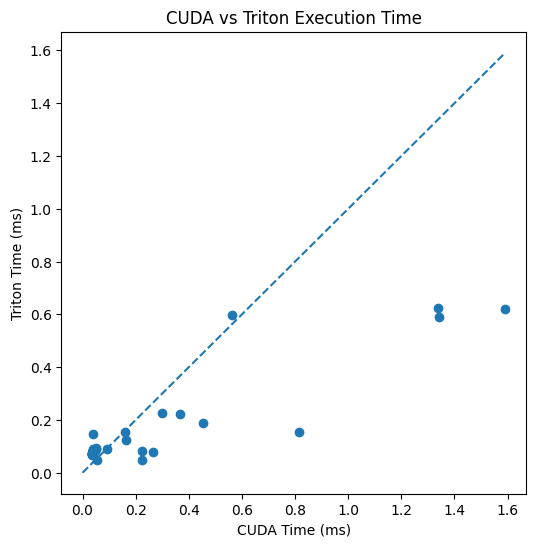

In [ ]:

import matplotlib.pyplot as plt
valid = df_results.dropna(subset=['cuda_ms','triton_ms'])
plt.figure(figsize=(6,6))
plt.scatter(valid['cuda_ms'], valid['triton_ms'])
m = max(valid['cuda_ms'].max(), valid['triton_ms'].max())
plt.plot([0,m],[0,m],'--')
plt.xlabel('CUDA Time (ms)'); plt.ylabel('Triton Time (ms)')
plt.title('CUDA vs Triton Execution Time')
plt.savefig('reports/cuda_vs_triton/cuda_vs_triton_scatter.png', dpi=150, bbox_inches='tight')
print("Saved plot to reports/cuda_vs_triton/cuda_vs_triton_scatter.png")


## Report Summary


In [ ]:

summary = {
    "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
    "cuda_available": bool(torch.cuda.is_available()),
    "sections": [
        "GPU check", "Installs", "Kernels", "LayerNorm", "Verification",
        "EvoNorm-B0 fused", "Conv+EvoNorm epilogue", "CNN training", "Benchmarks"
    ]
}
df = pd.DataFrame([summary])
display(df)
os.makedirs('reports/demo_pack', exist_ok=True) # Ensure directory exists
df.to_csv("reports/demo_pack/summary.csv", index=False)
print("✅ Saved: reports/demo_pack/summary.csv")


,gpu,cuda_available,sections
0,Tesla T4,True,"[GPU check, Installs, Kernels, LayerNorm, Veri..."


✅ Saved: reports/demo_pack/summary.csv


In [ ]:
# ================================
# 📌 Sequence-Length Benchmarks
# Goal 2: Compare perf across seq_len = 256, 512, 1024
# ================================

import time
import pandas as pd

def benchmark_softmax_seq_lengths(device="cuda"):
    results = []
    batch_size = 32
    d_model = 512
    seq_lengths = [256, 512, 1024]

    for L in seq_lengths:
        print(f"\nBenchmarking seq_len = {L} ...")
        x = torch.randn(batch_size, L, d_model, device=device)

        # Reshape to [N, D] for row-wise softmax
        x_2d = x.view(-1, d_model)

        # --- PyTorch softmax ---
        torch.cuda.synchronize()
        t0 = time.perf_counter()
        y_torch = torch.softmax(x_2d, dim=-1)
        torch.cuda.synchronize()
        torch_ms = (time.perf_counter() - t0) * 1e3

        # --- Triton softmax (if you have softmax_triton) ---
        # torch.cuda.synchronize()
        # t0 = time.perf_counter()
        # y_triton = softmax_triton(x_2d)
        # torch.cuda.synchronize()
        # triton_ms = (time.perf_counter() - t0) * 1e3

        # max_diff = (y_torch - y_triton).abs().max().item()

        results.append({
            "batch": batch_size,
            "seq_len": L,
            "d_model": d_model,
            "pytorch_ms": torch_ms,
            # "triton_ms": triton_ms,
            # "speedup": torch_ms / triton_ms,
            # "max_diff": max_diff,
        })

    df = pd.DataFrame(results)
    out_csv = "profiling/benchmark_results/softmax_seq_lengths.csv"
    df.to_csv(out_csv, index=False)

    print("\n===== Final Sequence Length Results =====")
    print(df)
    print(f"Saved → {out_csv}")

# Run the sequence length benchmark
benchmark_softmax_seq_lengths()



Benchmarking seq_len = 256 ...

Benchmarking seq_len = 512 ...

Benchmarking seq_len = 1024 ...

===== Final Sequence Length Results =====
   batch  seq_len  d_model  pytorch_ms
0     32      256      512    0.289186
1     32      512      512    1.539207
2     32     1024      512    1.116900
Saved → profiling/benchmark_results/softmax_seq_lengths.csv
